In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import json
import csv

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
from matplotlib.colors import to_hex

# Geospatial data
import geopandas as gpd

# Web requests
import requests
import glob
import os
from pathlib import Path

# Statistical tools
from scipy import stats
from scipy.stats import norm, ks_2samp
import statsmodels.api as sm
from scipy.stats import gaussian_kde

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to search for the folder named 'IPC_Bunching'
def find_folder(folder_name, start_directory):
    path = Path(start_directory)
    for folder in path.rglob('*'):
        if folder.is_dir() and folder.name == folder_name:
            return str(folder)  
    return None

# Set the folder name to search for and the start directory
folder_name = "IPC_Bunching"
start_directory = r"C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents"  # Replace with your starting directory

# Search for the folder
folder_path = find_folder(folder_name, start_directory)

# Output the result
if folder_path:
    print(f'Folder "{folder_name}" found at: {folder_path}')
else:
    print(f'Folder "{folder_name}" not found.')


Folder "IPC_Bunching" found at: C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\IPC_Bunching


In [3]:
# Set Home Path
home = folder_path

# Load Retrieved IPC - Population Tracking Tool (ipcinfo.org)

Downloaded the IPC population tracker data (as of 12/02/2023) from https://www.ipcinfo.org/ipc-country-analysis/population-tracking-tool/en/ which comprises of 10,890 entries as a main sample. Check Table A1 in the Appendix for more details.
    

In [4]:
# =============================================================
# Load Dataset
# =============================================================

concat_df = pd.read_csv(home + r'\stores\data\ipc_pop_tracker_12022023.csv')

# =============================================================
# Convert Strings to Float Fractions
# =============================================================

def convert_to_fraction(value):
    if isinstance(value, str) and value.endswith('%'):
        return str(float(value.strip('%')) / 100)
    return value

for col in ['phase1_perc', 'phase2_perc', 'phase3_perc', 'phase4_perc', 'phase5_perc']:
    concat_df[col] = concat_df[col].apply(convert_to_fraction).astype('float64')

# =============================================================
# Compute Cumulative Phase
# =============================================================

concat_df['phase5plus_perc'] = concat_df[['phase5_perc']].sum(axis=1).round(2)
concat_df['phase4plus_perc'] = concat_df[['phase4_perc', 'phase5_perc']].sum(axis=1).round(2)
concat_df['phase3plus_perc'] = concat_df[['phase3_perc', 'phase4_perc', 'phase5_perc']].sum(axis=1).round(2)
concat_df['phase2plus_perc'] = concat_df[['phase2_perc', 'phase3_perc', 'phase4_perc', 'phase5_perc']].sum(axis=1).round(2)
concat_df['phase1plus_perc'] = concat_df[['phase1_perc', 'phase2_perc', 'phase3_perc', 'phase4_perc', 'phase5_perc']].sum(axis=1).round(2)

# =============================================================
# Clean Population Column
# =============================================================

concat_df['estimated_population'] = concat_df['estimated_population'].str.replace(',', '').astype('float')

# =============================================================
# Filter Non-null Overall Phase Values
# =============================================================

cleaned_ipc_df = concat_df[concat_df['overall_phase'].notnull()]

# =============================================================
# Map Country Names to ISO Codes
# =============================================================

country_codes = {
    'Afghanistan': 'AFG', 'Bangladesh': 'BGD', 'Pakistan': 'PAK', 'Timor-Leste': 'TLS',
    'Burundi': 'BDI', 'Central African Republic': 'CAF', 'Congo, DRC': 'COD',
    'Djibouti': 'DJI', 'Ethiopia': 'ETH', 'Kenya': 'KEN', 'Somalia': 'SOM',
    'South Sudan': 'SSD', 'Sudan': 'SDN', 'Tanzania': 'TZA', 'Uganda': 'UGA',
    'Angola': 'AGO', 'Eswatini': 'SWZ', 'Lesotho': 'LSO', 'Madagascar': 'MDG',
    'Malawi': 'MWI', 'Mozambique': 'MOZ', 'Namibia': 'NAM', 'South Africa': 'ZAF',
    'Zambia': 'ZMB', 'Zimbabwe': 'ZWE', 'Dominican Republic': 'DOM', 'El Salvador': 'SLV',
    'Guatemala': 'GTM', 'Haiti': 'HTI', 'Honduras': 'HND', 'LAC Region (tri-National)': 'LAC',
    'Lebanon': 'LBN', 'Yemen': 'YEM'
}

cleaned_ipc_df['countrycode'] = cleaned_ipc_df['country_name'].replace(country_codes)

print('# of unique Country:', sorted(cleaned_ipc_df['countrycode'].unique()), cleaned_ipc_df['countrycode'].nunique())
print('# of Assessments for Sample A + A":', len(cleaned_ipc_df))

# =============================================================
# Generate Country X Round ID
# =============================================================

cleaned_ipc_df['index'] = cleaned_ipc_df.set_index(['country_name', 'yearmon']).index

# =============================================================
# Summary: Unique Counts by Country × Round
# =============================================================

total_notnulldf = cleaned_ipc_df['index'].value_counts().reset_index()

# of unique Country: ['AFG', 'AGO', 'BDI', 'BGD', 'CAF', 'COD', 'DJI', 'DOM', 'ETH', 'GTM', 'HND', 'HTI', 'KEN', 'LAC', 'LBN', 'LSO', 'MDG', 'MOZ', 'MWI', 'NAM', 'PAK', 'SDN', 'SLV', 'SOM', 'SSD', 'SWZ', 'TLS', 'TZA', 'UGA', 'YEM', 'ZAF', 'ZMB', 'ZWE'] 33
# of Assessments for Sample A + A": 10890


# Figure1. IPC coverage used in our analysis and geographic distribution of the proportion of population assessed in phase 3+ 

In [5]:
# Load Country level Shapefile
# downloaded from: https://datacatalog.worldbank.org/search/dataset/0038272/World-Bank-Official-Boundaries
shapefile_path = home + r'\stores\data\WB_countries_Admin0_10m\WB_countries_Admin0_10m.shp'
worldgdf = gpd.read_file(shapefile_path)

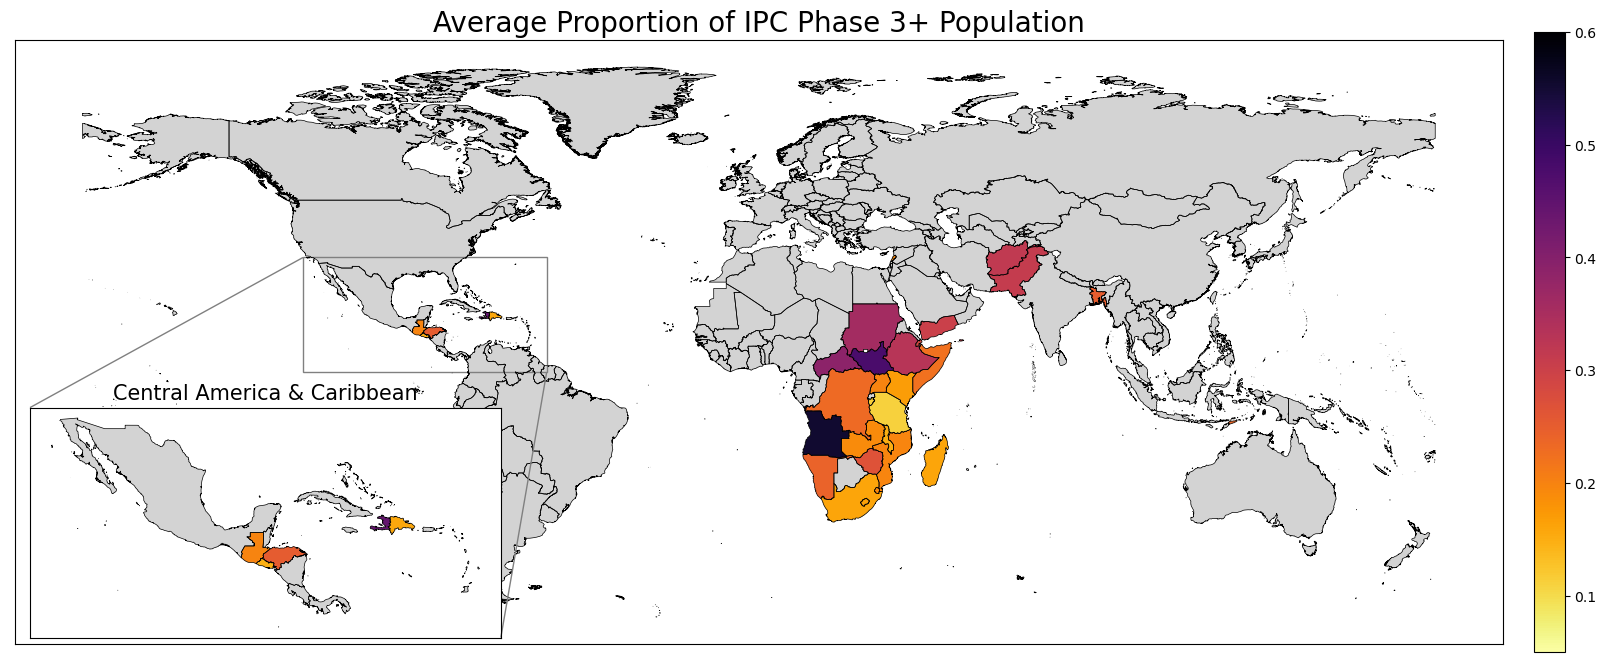

In [6]:
# =============================================================
# Setup Figure and Target Variable
# =============================================================

fig, ax = plt.subplots(figsize=(20, 10))
variable = 'phase3plus_perc'  # Phase 3+ Population Share (%)

# =============================================================
# Aggregate Stats: Mean, Max, Min, Median by Country
# =============================================================

first_rounds = [t[0] for t in cleaned_ipc_df.groupby('country_name')['index'].unique()]

country_mean_ipc = (
    cleaned_ipc_df[cleaned_ipc_df['index'].isin(first_rounds)]
    .groupby('countrycode')[['overall_phase', variable]]
    .mean()
    .reset_index()
    .rename(columns={'countrycode': 'ISO_A3'})
)

country_max_ipc = (
    cleaned_ipc_df[cleaned_ipc_df['index'].isin(first_rounds)]
    .groupby('countrycode')[['overall_phase', variable]]
    .max()
    .reset_index()
    .rename(columns={'countrycode': 'ISO_A3'})
)

country_min_ipc = (
    cleaned_ipc_df[cleaned_ipc_df['index'].isin(first_rounds)]
    .groupby('countrycode')[['overall_phase', variable]]
    .min()
    .reset_index()
    .rename(columns={'countrycode': 'ISO_A3'})
)

country_median_ipc = (
    cleaned_ipc_df[cleaned_ipc_df['index'].isin(first_rounds)]
    .groupby('countrycode')[['overall_phase', variable]]
    .median()
    .reset_index()
    .rename(columns={'countrycode': 'ISO_A3'})
)

# =============================================================
# Merge with GeoDataFrame and Handle Missing Values
# =============================================================

merged_worldgdf = worldgdf[['ISO_A3', 'geometry', 'SUBREGION']].merge(
    country_mean_ipc, on='ISO_A3', how='left'
)
merged_worldgdf['overall_phase'] = merged_worldgdf['overall_phase'].fillna(-1)

# =============================================================
# Base Map: Plot Boundaries and Fill by Phase 3+ Share
# =============================================================

merged_worldgdf.boundary.plot(ax=ax, color='black', linewidth=0.5)
merged_worldgdf[merged_worldgdf['overall_phase'] == -1].plot(
    column='overall_phase', ax=ax, legend=False, color='lightgray'
)

norm = mcolors.Normalize(vmin=0.05, vmax=0.60)
color_scheme = 'inferno_r'

cax = merged_worldgdf.plot(
    column=variable, ax=ax, cmap=color_scheme, norm=norm, legend=False
)

sm = plt.cm.ScalarMappable(cmap=color_scheme, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, fraction=0.02, pad=0.02)

# =============================================================
# Inset Map: Central America and Caribbean Zoom-In
# =============================================================

central_america_caribbean = merged_worldgdf[
    merged_worldgdf['SUBREGION'].isin(['Central America', 'Caribbean'])
]

axins = zoomed_inset_axes(ax, zoom=2, loc='lower left')

central_america_caribbean.boundary.plot(ax=axins, color='black', linewidth=0.5)
central_america_caribbean[central_america_caribbean['overall_phase'] == -1].plot(
    column='overall_phase', ax=axins, legend=False, color='lightgray'
)

central_america_caribbean.plot(
    column=variable, ax=axins, cmap=color_scheme, norm=norm, legend=False
)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# =============================================================
# 6. Plot Formatting
# =============================================================

ax.set_title('Average Proportion of IPC Phase 3+ Population', fontsize=20)
axins.set_title('Central America & Caribbean', fontsize=15)

ax.set_xticks([])
ax.set_yticks([])
axins.set_xticks([])
axins.set_yticks([])

plt.show()


Below we check how often IPC Phase 3+ percentage values are rounded to standard intervals (e.g., 0.05, 0.10,..., 0.95) across country-round combinations. It splits the data into rounded and non-rounded groups, counts the frequency of each group by country and round, and calculates the proportion of rounded values relative to total entries. Based on a specified threshold (e.g., 50%), it flags groups with a high share of rounding, separates the dataset accordingly, and calculates the product of population and Phase 3+ percentage for the rounded-dominant subset to assess the impact.

In [7]:
# =============================================================
# 1. Define Rounded Values (0.00 to 0.95 by 0.05)
# =============================================================

roundnumber = np.arange(0, 1, 0.05).round(2)

# =============================================================
# 2. Split into Rounded vs. Non-Rounded phase3plus_perc
# =============================================================

notround_df = cleaned_ipc_df[~cleaned_ipc_df['phase3plus_perc'].isin(roundnumber)]
round_df     = cleaned_ipc_df[ cleaned_ipc_df['phase3plus_perc'].isin(roundnumber)]

# =============================================================
# 3. Create Country X Round Index and Count Assessments
# =============================================================

notround_df['index'] = notround_df.set_index(['country_name', 'yearmon']).index
round_df['index']    = round_df.set_index(['country_name', 'yearmon']).index

notround_df = notround_df['index'].value_counts().reset_index().rename(columns={'index': 'count'})
round_df    = round_df['index'].value_counts().reset_index().rename(columns={'index': 'count'})

# =============================================================
# 4. Merge Rounded Counts with Total and Compute "Rounding" Share
# =============================================================

merge_df   = round_df.copy()
compare_df = total_notnulldf.merge(merge_df, on='level_0')  # `level_0` = index column from total_notnulldf
compare_df['diff_count'] = compare_df['count'] / compare_df['index']  # Share of rounded values

# =============================================================
# 5. Filter by Rounding Threshold and Split Final Datasets
# =============================================================

rate = 0.50  # Minimum share of rounded values required to Define Sample A in Table A1

cleaned_ipc_df['index'] = cleaned_ipc_df.set_index(['country_name', 'yearmon']).index

matching_indices = compare_df[compare_df['diff_count'] >= rate]['level_0'].unique()

# Sample A: Majority-rounded data; Sample A": Less-rounded or unrounded
rounded_df    = cleaned_ipc_df[ cleaned_ipc_df['index'].isin(matching_indices)].copy()
rounded_df_nr = cleaned_ipc_df[~cleaned_ipc_df['index'].isin(matching_indices)].copy()

# =============================================================
# 6. Compute 3+ Population for Rounded Sample
# =============================================================

rounded_df['phase3plus_product'] = rounded_df['estimated_population'] * rounded_df['phase3plus_perc']

# =============================================================
# 7. Print Summary
# =============================================================

print('Sample A:', len(rounded_df), '\n','Sample A":', len(rounded_df_nr))


Sample A: 9394 
 Sample A": 1496


# Figure 2. Comparison of observed and estimated distributions of IPC classifications, based on population shares in Phase 3+ (%). 

In [8]:
from bunching_analysis import BunchingAnalysis

In [9]:
# Initialize the simulator
sim = BunchingAnalysis(
    data_series=rounded_df['phase3plus_perc'],
    poly_degree=4,
    seed=123
)

# ---------------------------------------------------------------
# Scenario 1: Polynomial fitting with multiple excluded bins (e.g., 15, 20, 25, 30 %)
# ---------------------------------------------------------------
_, mean_coefficients1, std_error1 = sim.scenario1(
    num_simulations=500,
    exclude_points=[0.175, 0.225, 0.275, 0.325]
)

# ---------------------------------------------------------------
# Scenario 2: Full-bin bootstrap simulation without exclusions
# ---------------------------------------------------------------
_, mean_coefficients2, std_error2 = sim.scenario2(num_simulations=500)

# ---------------------------------------------------------------
# Scenario 3: Threshold-centered exclusion simulation (excludes ± binwidth around zstar)
# ---------------------------------------------------------------
_, mean_coefficients3, std_error3 = sim.scenario3(
    num_simulations=500,
    zstar=0.20
)

Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300


In [10]:
# Summary of Binned ORiginal Data

rounded_with_bins= sim.add_bin_midpoint_column(rounded_df,'phase3plus_perc' )

summary = rounded_with_bins.groupby('bin_midpoint')['estimated_population'].agg(
    **{
        'average population (in millions)': 'mean',
        'original_observation': 'count'
    }
).reset_index()

summary

,bin_midpoint,average population (in millions),original_observation
0,0.00,420849.546154,260
1,0.05,326115.705128,624
2,0.10,363403.828571,735
3,0.15,375568.920884,1403
4,0.20,294482.527721,974
5,0.25,311990.739496,833
6,0.30,332749.064603,743
7,0.35,256502.142322,801
8,0.40,272526.204330,739
9,0.45,304929.314685,572


Following block generates a two-panel visualization to compare observed and simulated distributions of food insecurity phases and quantify anomalies. The first plot shows observed binned frequencies of Phase 3+ population percentages alongside three sets of simulated frequency estimates, each with confidence intervals. It highlights the region excluded during estimation (0.15–0.30) to visually assess divergence. The second plot displays "excess mass"—the difference between observed and simulated frequencies—for each bin, with error bars and shaded annotations emphasizing statistically significant deviations. This combined view helps identify bins where rounding or reporting artifacts may systematically inflate observed values relative to model-based expectations.

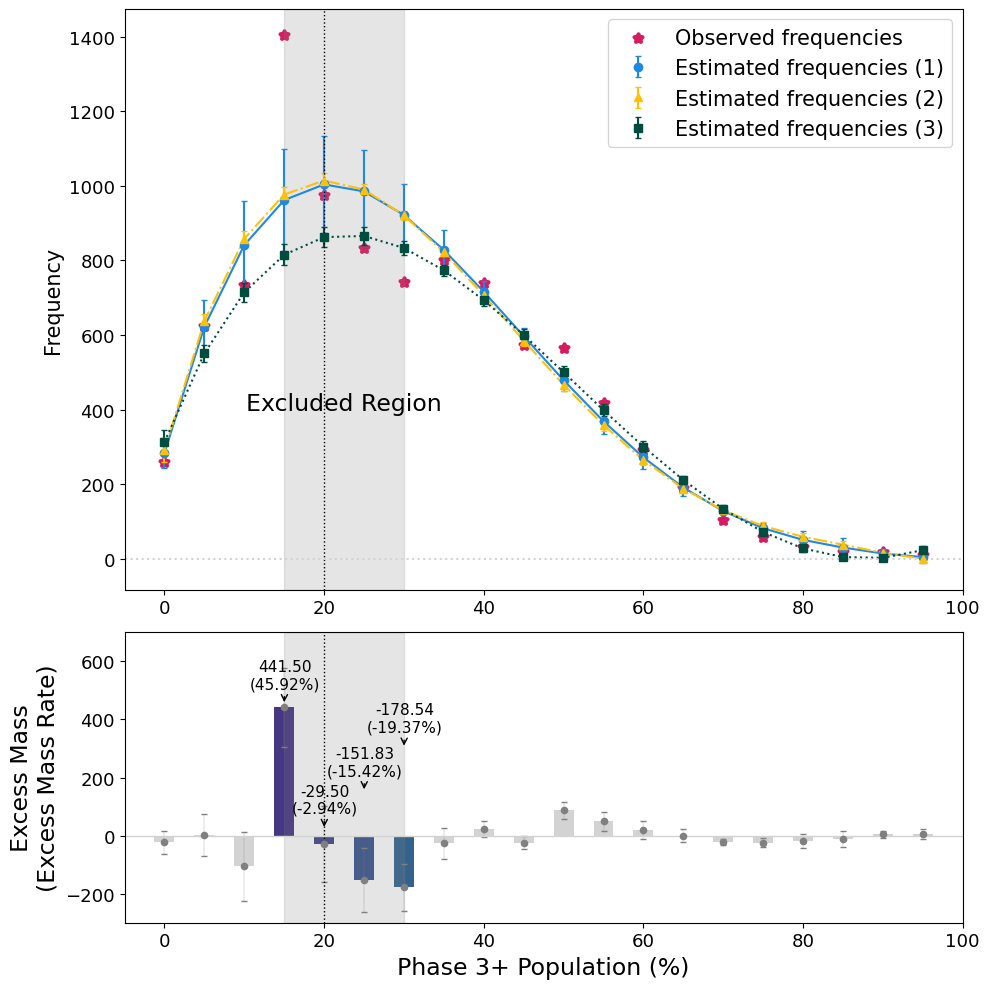

In [11]:
# =============================================================
# Midpoints and Original Data
# =============================================================
bin_midpoints = np.array(summary['bin_midpoint'])
binned_data_orig = np.array(summary['original_observation'])

# =============================================================
# Aggregate Simulation 1 Results into df
# =============================================================
agg_df = pd.DataFrame({
    'bins': bin_midpoints,
    'binned_data_orig': binned_data_orig,
    'mean_coefficients': mean_coefficients1,
    'std_errors': std_error1
})
agg_df['excess_mass'] = agg_df['binned_data_orig'] - agg_df['mean_coefficients']
agg_df['excess_mass_perc'] = agg_df['excess_mass'] / agg_df['mean_coefficients']

# =============================================================
# Figure Set-up
# =============================================================
fig, axs = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})

# =============================================================
# Plot 1 – Observed vs Estimated Frequencies (Simulation 1, 2, 3)
# =============================================================
axs[0].scatter(bin_midpoints, binned_data_orig, label="Binned Data", color='#D81B60', marker='*', linewidth=3)

handle1 = axs[0].errorbar(bin_midpoints, mean_coefficients1, yerr=std_error1 * 2, fmt='o', color='#1E88E5', capsize=2)
handle2 = axs[0].errorbar(bin_midpoints, mean_coefficients2, yerr=std_error2 * 2, fmt='^', color='#FFC107', capsize=2)
handle3 = axs[0].errorbar(bin_midpoints, mean_coefficients3, yerr=std_error3 * 2, fmt='s', color='#004D40', capsize=2)

axs[0].plot(bin_midpoints, mean_coefficients1, color='#1E88E5')
axs[0].plot(bin_midpoints, mean_coefficients2, color='#FFC107', linestyle='-.')
axs[0].plot(bin_midpoints, mean_coefficients3, color='#004D40', linestyle=':')

axs[0].axvline(0.20, color='black', linestyle=':', linewidth=1)
axs[0].axhline(0.0, color='lightgray', linestyle=':')

axs[0].legend(
    [axs[0].collections[0], handle1, handle2, handle3],
    ['Observed frequencies', 'Estimated frequencies (1)', 'Estimated frequencies (2)', 'Estimated frequencies (3)'],
    loc='upper right', fontsize=15
)

axs[0].axvspan(0.15, 0.30, color='gray', alpha=0.2)
axs[0].set_xlim([-0.05, 1.0])
axs[0].set_xticks(np.arange(0, 1.2, 0.2))
axs[0].set_xticklabels(np.arange(0, 120, 20))
axs[0].annotate("Excluded Region", (0.225, 400), ha='center', fontsize=17)
axs[0].set_ylabel('Frequency', fontsize=15)

# =============================================================
# Plot 2 – Excess Mass from Simulation 1
# =============================================================
agg_df['bins'] = pd.Categorical(agg_df['bins'], categories=np.sort(agg_df['bins'].unique()), ordered=True)
x_range = [0.15, 0.20, 0.25, 0.30]

colors = ['viridis_r' if x in x_range else 'gray' for x in agg_df['bins']]
cmap_vals = np.linspace(0, 1, len(colors))
actual_colors = [
    to_hex(viridis(cmap_vals[i])) if c == 'viridis_r' else 'lightgray'
    for i, c in enumerate(colors)
]

axs[1].bar(agg_df['bins'], agg_df['excess_mass'], width=0.025, color=actual_colors)
axs[1].errorbar(agg_df['bins'], agg_df['excess_mass'], yerr=agg_df['std_errors'] * 2,
                fmt='o', color='gray', elinewidth=0.2, capsize=2, markersize=4.5)

agg_df['y_loc'] = [0, 0, 0, 450, 20, 150, 300] + [0] * (len(agg_df) - 7)
agg_df['x_loc'] = [0, 0, 0, 0.15, 0.20, 0.225, 0.335] + [0] * (len(agg_df) - 7)

for p, bin_val, perc, x, y in zip(axs[1].patches, agg_df['bins'], agg_df['excess_mass_perc'],
                                  agg_df['x_loc'], agg_df['y_loc']):
    if bin_val in x_range:
        axs[1].annotate(
            f"{p.get_height():.2f}\n({perc*100:.2f}%)",
            xy=(p.get_x() + p.get_width() / 2, y),
            xytext=(0.5, 10),
            textcoords="offset points",
            ha='center', va='bottom', fontsize=11, color='black',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black')
        )

axs[1].axvline(0.20, color='black', linestyle=':', linewidth=1)
axs[1].axhline(0, color='lightgray', linewidth=1)
axs[1].axvspan(0.15, 0.30, color='gray', alpha=0.2)

axs[1].set_xticks(np.arange(0, 1.2, 0.2))
axs[1].set_xticklabels(np.arange(0, 120, 20))
axs[1].set_xlim([-0.05, 1.0])
axs[1].set_ylim([-300, 700])
axs[1].set_xlabel('Phase 3+ Population (%)', fontsize=17)
axs[1].set_ylabel('Excess Mass\n(Excess Mass Rate)', fontsize=17)

axs[0].tick_params(labelsize=13)
axs[1].tick_params(labelsize=13)

plt.tight_layout()
plt.show()


### Back of the envelope calculation for undercounting population around the 20% threshold (from Sample A)

In [12]:
# Estimate the phase 3+ population (15–30% range)
back_env_calculation = rounded_with_bins[
    (rounded_with_bins['bin_midpoint'] >= 0.15) &
    (rounded_with_bins['bin_midpoint'] <= 0.30)
]

phase3plus_pop_15to30 = (
    (back_env_calculation['estimated_population'] *
     back_env_calculation['phase3plus_perc']).sum()
) / 1_000_000

# Average population in areas at the 15% bin (used as baseline)
avg_pop_15 = (
    rounded_with_bins[rounded_with_bins['bin_midpoint'] == 0.15]['estimated_population']
    .mean()
) / 1_000_000

print("Total Phase 3+ population 15–30% (million):", phase3plus_pop_15to30)
print("Average population at 15% bin (million):", avg_pop_15)

# Estimate undercounted Phase 3+ population based on excess mass (see simple equation in the )
total_undercounted_3plus_pop = 0
for n in [0.20, 0.25, 0.30]:
    total_undercounted_3plus_pop += (
        agg_df[agg_df['bins'] == n]['excess_mass'].sum()
        * avg_pop_15
        * (n - 0.15)
    )

print("Total undercounted Phase 3+ population (million):", abs(total_undercounted_3plus_pop))

# Undercount ratio relative to the total Phase 3+ population in the 15–30% range
undercount_ratio = abs(total_undercounted_3plus_pop) / phase3plus_pop_15to30
print("Undercount ratio (share of Phase 3+ population) in the range 15-30%:", undercount_ratio)


Total Phase 3+ population 15–30% (million): 277.15695346999996
Average population at 15% bin (million): 0.3755689208838204
Total undercounted Phase 3+ population (million): 16.314426405511135
Undercount ratio (share of Phase 3+ population) in the range 15-30%: 0.05886349305422367


# Figure 2 Continue: Country Level Bunching Analysis

*simulation running for: Afghanistan
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
*simulation running for: Congo, DRC
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
*simulation running for: Lebanon
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
*simulation running for: Madagascar
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
*simulation running for: South Sudan
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
*simulation running for: Yemen
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300


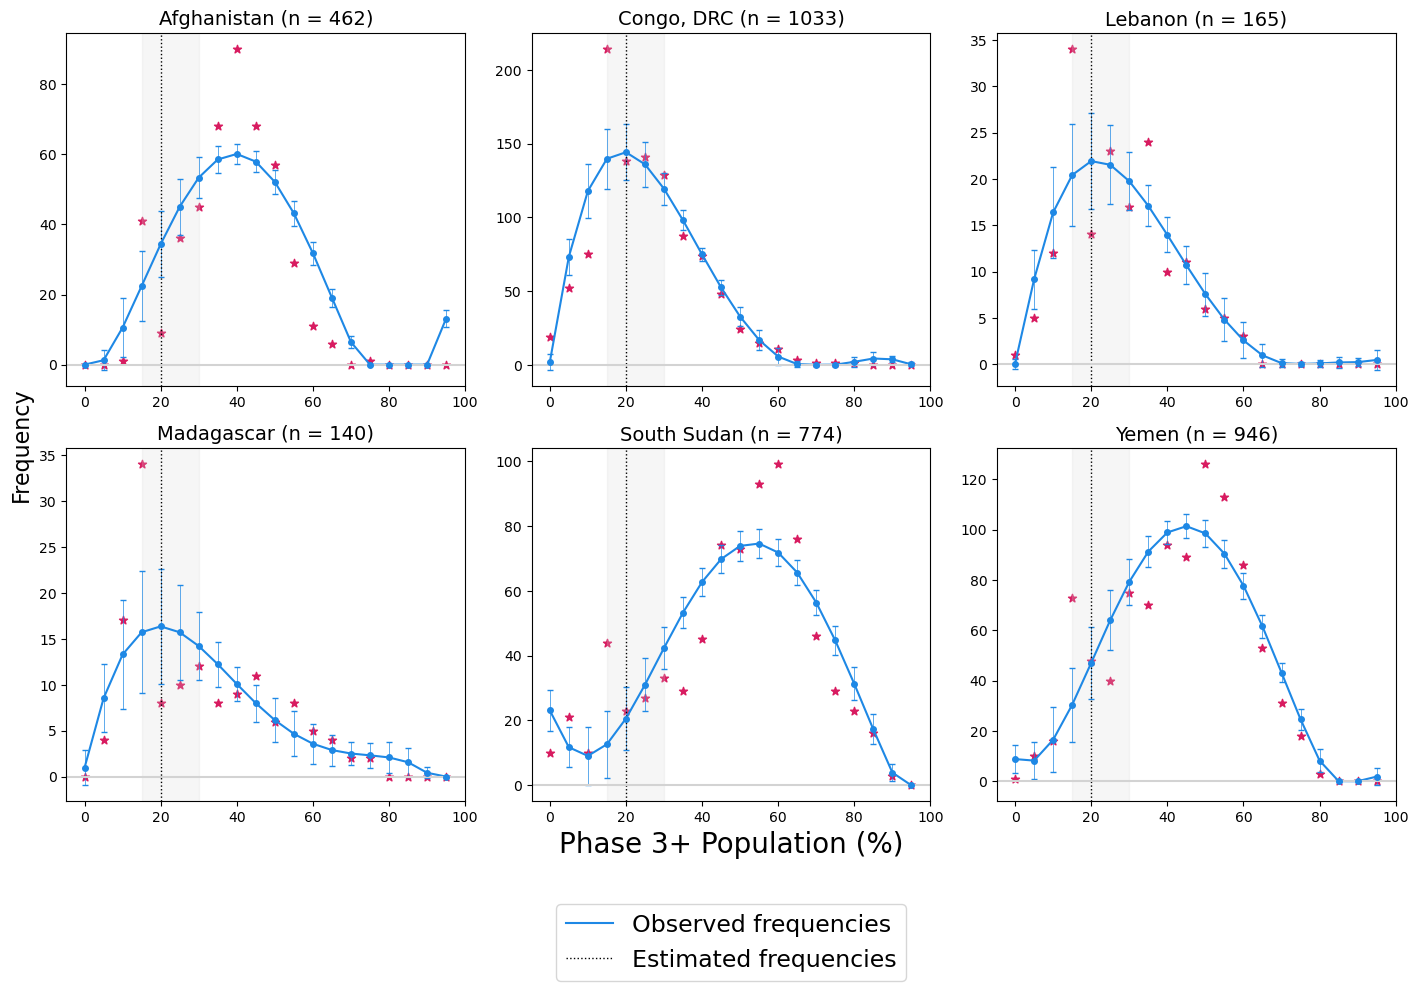

In [13]:
# =============================================================
# Set parameters
# =============================================================
var = 'phase3plus_perc'
countries = sorted(['Afghanistan', 'Congo, DRC', 'Madagascar', 'South Sudan', 'Yemen', 'Lebanon'])
binwidth = 0.05
poly_degree = 4
num_simulations = 500
exclude_areas = ['KAWANGWARE', 'MUKURU', 'GITHURAI', 'KANGEMI', 'KAYOLE', 'BANGLADESH', 'DANDORA', 
                 'OBUNGA', 'KONDELE', 'KIBRA', 'MWEMBE TAYARI', 'MATHARE']
exclude_index = []

# =============================================================
# Set Up Subplots
# =============================================================
fig, axes = plt.subplots(len(countries)//3, 3, figsize=(14, 10))
agg = []

# =============================================================
# Iterate by country and run simulations
# =============================================================
for i, c in enumerate(countries):
    sub_df = rounded_df[
        (rounded_df['country_name'] == c) &
        ~(rounded_df['Area'].isin(exclude_areas)) &
        ~(rounded_df['index'].isin(exclude_index))
    ]
    data_series = sub_df[var].dropna()
    if data_series.empty:
        continue

    # Initialize simulator
    sim = BunchingAnalysis(data_series, binwidth=binwidth, poly_degree=poly_degree)
    
    # Run simulation 1
    print('*simulation running for:', c)
    coeff_matrix, mean_coeffs, se_coeffs = sim.scenario1(num_simulations=num_simulations)

    # ---------------------------------------------------------
    # subplot setup
    # ---------------------------------------------------------
    row, col = i // 3, i % 3
    ax = axes[row, col]

    # Plot observed data
    counts, _ = np.histogram(data_series.round(2), bins=sim.bins.round(2))
    ax.scatter(sim.midpoints - binwidth / 2, counts, label='Observed', color='#D81B60', marker='*')

    # Plot estimated data with error bars
    ax.errorbar(sim.midpoints - binwidth / 2, mean_coeffs, yerr=se_coeffs * 2,
                fmt='o', color='#1E88E5', ecolor='#1E88E5', elinewidth=0.5, capsize=2, markersize=4)

    # Line plot for estimated values
    ax.plot(sim.midpoints - binwidth / 2, mean_coeffs, color='#1E88E5')

    # Plot features
    ax.axvline(x=0.20, color='black', linestyle=':', linewidth=1)
    ax.axvspan(0.15, 0.30, color='lightgray', alpha=0.2)
    ax.axhline(y=0.0, color='lightgray')
    ax.set_title(f'{c} (n = {len(sub_df)})', fontsize=14)
    ax.set_xticks(np.arange(0, 1.05, 0.2))
    ax.set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)])
    ax.tick_params(axis='both', labelsize=10)

    # legend in the center plot
    if (row == 1) & (col == 1):
        ax.legend(['Observed frequencies', 'Estimated frequencies'], 
                  bbox_to_anchor=(0.5, -0.4), ncol=1, loc="center", fontsize=17)
        ax.set_xlabel('Phase 3+ Population (%)', fontsize=20)

    # ---------------------------------------------------------
    # Aggregate Simulation Results
    # ---------------------------------------------------------
    agg_df = pd.DataFrame({
        'bin': sim.midpoints - binwidth / 2,
        'observed': counts,
        'estimated': mean_coeffs
    })
    agg_df['excess_mass'] = (agg_df['observed'] - agg_df['estimated']) / agg_df['estimated']
    agg_df['country'] = c
    agg.append(agg_df)

# =============================================================
# Final version
# =============================================================
plt.tight_layout()
fig.text(-0.01, 0.55, 'Frequency', va='center', rotation='vertical', fontsize=16)
plt.show()

# Figure 3 to 5 in the main text rely on IPC data with confidential underlying indicators (Sample B from Table A1.)

In [14]:
# =============================================================
# Load Sample B and Prepare Data
# =============================================================
ipc_df_sub = pd.read_csv(home + r'\stores\data\ipc_sample_c3.csv')  

# Filter to selected FSI indicator combinations
ipc_df_sub = ipc_df_sub[
    ipc_df_sub['FSI_combination'].isin([
        'FCS-RCSI-HHS-LCS-HDDS', 
        'FCS-RCSI-HHS-LCS', 
        'FCS-RCSI-LCS-HDDS', 
        'FCS-RCSI-LCS'
    ])
]  

def round_to_nearest_5_percent(series):
    """Round values (0–1) to the nearest 0.05 (5%)."""
    return np.round(series / 0.05) * 0.05

ipc_df_sub['average3_up'] = round_to_nearest_5_percent(ipc_df_sub['average_3plus'])  # Round phase 3+ averages to 5% bins


In [15]:
# =============================================================
# Standardize country names
# =============================================================
country_codes_updated = {
    'Madagascar': 'Madagascar',
    'Ethiopia': 'Ethiopia',
    'Djibouti': 'Djibouti',
    'Lebanon': 'Lebanon',
    'Kenya': 'Kenya',
    'Haiti': 'Haiti',
    'Guatemala': 'Guatemala',
    'Yemen': 'Yemen',
    'Pakistan': 'Pakistan',
    'Mozambique': 'Mozambique',
    'South Sudan': 'South Sudan',
    'Congo': 'Congo, DRC',  # Democratic Republic of the Congo
    'CAR': 'Central African Republic',
    'Afghanistan': 'Afghanistan',
    'Sudan': 'Sudan'
}

ipc_df_sub['country_name'] = ipc_df_sub['country'].replace(country_codes_updated)

# =============================================================
# Create Country X Round Index for Grouping
# =============================================================
ipc_df_sub['index'] = ipc_df_sub.set_index(['country_name', 'yearmon']).index

# =============================================================
# Round Key FSI implied population to Nearest 5% for consistency
# =============================================================
def round_to_nearest_5(num):
    return np.round(num / 5) * 5

cols_to_round = ['phase3_plus', 'FCS_3plus', 'rCSI_3plus', 'hhs_3plus', 'lcs_3plus', 'hdds_3plus']

for col in cols_to_round:
    ipc_df_sub[f'{col}_up'] = round_to_nearest_5(ipc_df_sub[col] * 100) / 100
ipc_df_sub[[t for t in ipc_df_sub if t.endswith('_up')][:6] +['average3_up']]

,phase3_plus_up,FCS_3plus_up,rCSI_3plus_up,hhs_3plus_up,lcs_3plus_up,hdds_3plus_up,average3_up
0,0.45,0.75,0.70,0.40,0.35,0.65,0.60
1,0.55,0.70,0.75,0.50,0.60,0.60,0.65
2,0.40,0.55,0.50,0.30,0.30,0.65,0.45
3,0.30,0.55,0.30,0.15,0.35,0.65,0.40
4,0.40,0.65,0.55,0.60,0.45,0.65,0.60
...,...,...,...,...,...,...,...
1844,0.15,0.20,0.00,NaN,0.10,NaN,0.10
1845,0.25,0.30,0.00,NaN,0.10,NaN,0.15
1846,0.25,0.50,0.00,NaN,0.40,NaN,0.30
1847,0.25,0.10,0.10,NaN,0.10,NaN,0.10


# Figure 3: Comparisons of distributions of IPC assessments defined by proportion of population in phase 3+ (Observed vs Counterfactual)

In [16]:
import statsmodels.api as sm

In [17]:
# =============================================================
# Estimate Phase 3+ Population share using FSI implied 3+ combinations
# =============================================================
# This code estimates Phase 3+ population shares using different FSI combinations.
# It fits OLS models for each unique FSI combination and generates predicted values for use in Figure A3 (Appendix).

def run_ols_and_predict(y, X):
    y = pd.Series(y)
    X = pd.DataFrame(X)
    df = pd.concat([y, X], axis=1).dropna()
    y_clean = df.iloc[:, 0]
    X_clean = sm.add_constant(df.iloc[:, 1:])
    model = sm.OLS(y_clean, X_clean).fit()
    return model.summary(), model.predict(X_clean)

# FSI combinations and corresponding variable names
combi_match = {
    'FCS-RCSI-HHS-LCS'    : ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up'],
    'FCS-RCSI-HHS-LCS-HDDS': ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'],
    'FCS-RCSI-LCS'        : ['FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up'],
    'FCS-RCSI-LCS-HDDS'   : ['FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']
}

# Apply OLS and generate predictions for each combination
combine_df = []

for i in ipc_df_sub['FSI_combination'].unique():
    subdf = ipc_df_sub[ipc_df_sub['FSI_combination'] == i]
    result = run_ols_and_predict(subdf['phase3_plus'], subdf[combi_match[i]])
    subdf['fsi_predicted'] = result[1]
    combine_df.append(subdf['fsi_predicted'])

# =============================================================
# Combine predictions into main df
# =============================================================
ipc_df_sub['fsi_predicted'] = pd.concat(combine_df)

In [18]:
# =============================================================
# Creating Counterfactual measures per Area Assessment (or unit)
# =============================================================

# Worst, and Average FSI 3+ Values across Five Indicators
ipc_df_sub['worst_fsi'] = ipc_df_sub[[
    'FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 
    'lcs_3plus_up', 'hdds_3plus_up'
]].max(axis=1)

ipc_df_sub['average_3plus'] = ipc_df_sub[[
    'FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 
    'lcs_3plus_up', 'hdds_3plus_up'
]].mean(axis=1)


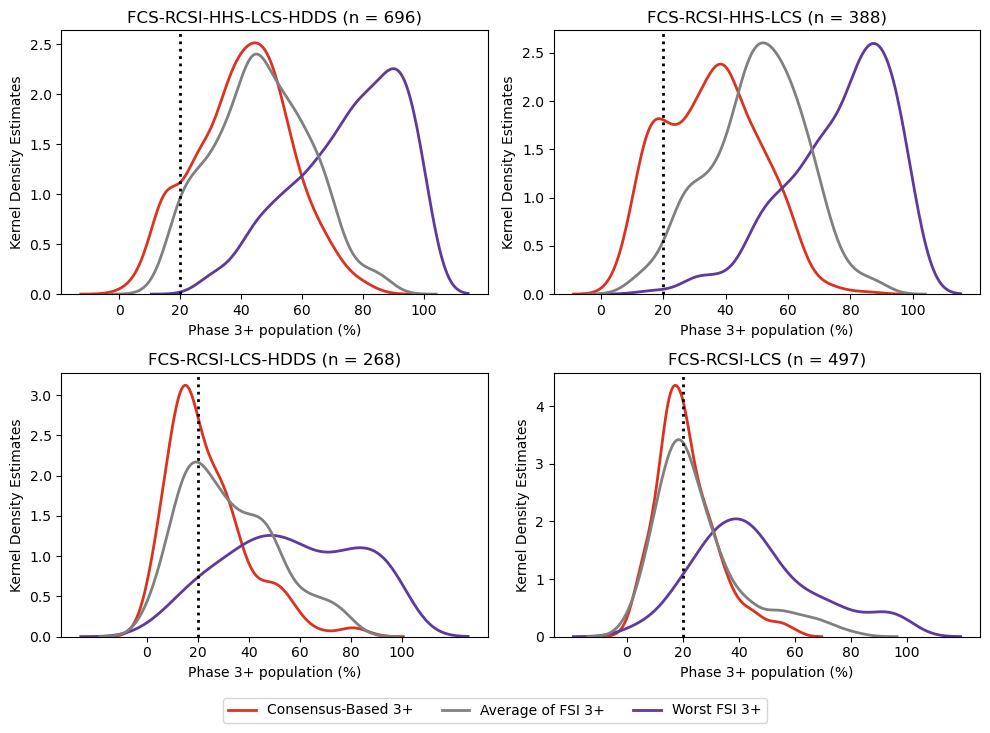

In [19]:
# =============================================================
# Plotting Distribution of Phase 3+ Estimates by FSI Combination
# =============================================================

# Define unique combinations to loop through
unique_combinations = ['FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-HHS-LCS', 
                       'FCS-RCSI-LCS-HDDS', 'FCS-RCSI-LCS']

# Create a 2x2 subplot grid
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

# Iterate through FSI combinations
for i, g in enumerate(unique_combinations):
    row, col = i // 2, i % 2
    subset = ipc_df_sub[ipc_df_sub['FSI_combination'] == g]
    
    sns.kdeplot(subset['phase3_plus'], ax=ax[row, col], linewidth=2, color='#DC3220', label='Consensus-Based 3+')
    sns.kdeplot(subset['worst_fsi'], ax=ax[row, col], linewidth=2, color='#5D3A9B', label='Worst FSI 3+')
    sns.kdeplot(subset['average_3plus'], ax=ax[row, col], linewidth=2, color='gray', label='Average of FSI 3+')
    
    ax[row, col].set_title(f"{g} (n = {len(subset)})")
    ax[row, col].set_xlabel('Phase 3+ population (%)')
    ax[row, col].set_ylabel('Kernel Density Estimates')
    ax[row, col].axvline(x=0.2, color='black', linewidth=2, linestyle=':')
    ax[row, col].set_xticks(np.arange(0, 1.05, 0.2))
    ax[row, col].set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)])
    ax[row, col].grid(False)

# =============================================================
# Cleanup Extra Subplot
# =============================================================
for i in range(len(unique_combinations), 4):
    fig.delaxes(ax[i // 2, i % 2])

plt.tight_layout()

# =============================================================
# Legend (Consistent Across Subplots)
# =============================================================
handles, labels = ax[0, 0].get_legend_handles_labels()
desired_order = ['Consensus-Based 3+', 'Average of FSI 3+', 'Worst FSI 3+']
ordered_handles = [handles[labels.index(label)] for label in desired_order]

fig.legend(ordered_handles, desired_order, loc='lower center', 
           bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=10)

plt.show()


### Back of the envelope calculation for undercounting population around the 20% threshold (from Sample B n=1849)

In [20]:
# =============================================================
# Back-of the-envelope calculation, Phase 3+ Population Estimates — Sample B (n = 1,849)
# =============================================================

# Phase 3+ population between 15–30% of the distribution (≈73.7 million baseline)
back_env_calculation = ipc_df_sub[
    (ipc_df_sub['phase3_plus_up'] >= 0.15) &
    (ipc_df_sub['phase3_plus_up'] <= 0.30)
]
sum((back_env_calculation['estimated_population'] * back_env_calculation['phase3_plus_up'])) / 1_000_000

# Phase 3+ population between 15–30% of the distribution (≈277.2 million, model-adjusted)
back_env_calculation = ipc_df_sub[
    (ipc_df_sub['phase3_plus_up'] >= 0.15) &
    (ipc_df_sub['phase3_plus_up'] <= 0.30)
]
phase3plus_pop_15to30 = (
    (back_env_calculation['estimated_population'] *
     back_env_calculation['phase3_plus_up']).sum()
) / 1_000_000
print("Phase 3+ population 15–30% (million):", phase3plus_pop_15to30)

# Undercounted population within the 15–30% Phase 3+ range
print("Undercounted Phase 3+ population (million) - 15-30% region:", abs(undercount_ratio) * phase3plus_pop_15to30)

# Share of this undercount relative to total undercounted population agnsits FSI mean counterfactual (around 66.2 million from Figure 4 Panel 2)
print("Share of total undercounted population:", abs(undercount_ratio) * phase3plus_pop_15to30 / 66.2)


Phase 3+ population 15–30% (million): 73.7247673
Undercounted Phase 3+ population (million) - 15-30% region: 4.339697327887806
Share of total undercounted population: 0.06555434030042002


# Figure 4. Distribution of the difference between consensus-based 3+ population (%) and the arithmetic mean of FSI implied 3+ populations (%) for IPC assessments and number of undercounted populations in phase 3+ using counterfactual distributions estimates by FSI availability group.

In [21]:
# =============================================================
# Data prep for Figure 4 - Upper Panel
# =============================================================
# Exclude irrelvant combination
df = ipc_df_sub[ipc_df_sub['FSI_combination'] != 'FCS-RCSI-HHS-HDDS'].copy()


# Y-axis variables: Difference between observed and average estimates
df['diff'] = (df['phase3_plus_up'] - df['average3_up']).round(2)
df['diff_abs'] = (abs(df['phase3_plus_up'] - df['average3_up'])).round(2)

# X-axis variables: Spread of individual FSIs
fsi_set = ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']
df['diff_minmax'] = (df[fsi_set].max(axis=1) - df[fsi_set].min(axis=1)).round(2)
df['fi_sd'] = (df[fsi_set].std(axis=1)).round(2)

# Labeling observations based on sign of difference
df['obs-avg'] = np.where(df['diff'] > 0, 'positive', 'negative')
df['obs-avg'] = np.where(df['diff'] == 0, 'no difference', df['obs-avg'])


# =============================================================
# Data Preparation for Figure 4 - Bottom Panel: Aggregated Populations
# =============================================================

# Container to store calculated results
results = []

# Loop through key FSI combinations and target columns
for g in ['FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-HHS-LCS', 'FCS-RCSI-LCS-HDDS', 'FCS-RCSI-LCS']:
    for i in ['phase3_plus', 'average_3plus', 'worst_fsi']:
        
        plot_df = ipc_df_sub[
            ipc_df_sub['FSI_combination'].isin([
                'FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-HHS-LCS', 
                'FCS-RCSI-LCS-HDDS', 'FCS-RCSI-LCS'
            ])
        ]

        # Weighted sums in millions
        counter_three_plus = (plot_df[i] * plot_df['estimated_population']).sum() / 1_000_000
        observed_three_plus = (plot_df['phase3_plus'] * plot_df['estimated_population']).sum() / 1_000_000
        total = plot_df['estimated_population'].sum() / 1_000_000
        ratio = (counter_three_plus / observed_three_plus) * 100

        # Store row result
        results.append({
            'FSI_combination': g,
            'Column': i,
            'Counter_ThreePlus_Millions': counter_three_plus,
            'observed_3plusPop_Millions': observed_three_plus,
            'total': total,
            'Ratio': ratio
        })

# =============================================================
# Final Assembly of Result Table
# =============================================================

results_df = pd.DataFrame(results)
results_df['Diff_3plusPop_Millions'] = abs(
    results_df['observed_3plusPop_Millions'] - results_df['Counter_ThreePlus_Millions']
)
results_df['Ratio'] = (
    results_df['Diff_3plusPop_Millions'] / results_df['observed_3plusPop_Millions']
) * 100

# Output DataFrame
results_df

,FSI_combination,Column,Counter_ThreePlus_Millions,observed_3plusPop_Millions,total,Ratio,Diff_3plusPop_Millions
0,FCS-RCSI-HHS-LCS-HDDS,phase3_plus,226.876114,226.876114,743.34164,0.000000,0.000000
1,FCS-RCSI-HHS-LCS-HDDS,average_3plus,293.120842,226.876114,743.34164,29.198635,66.244728
2,FCS-RCSI-HHS-LCS-HDDS,worst_fsi,488.156458,226.876114,743.34164,115.164324,261.280344
3,FCS-RCSI-HHS-LCS,phase3_plus,226.876114,226.876114,743.34164,0.000000,0.000000
4,FCS-RCSI-HHS-LCS,average_3plus,293.120842,226.876114,743.34164,29.198635,66.244728
5,FCS-RCSI-HHS-LCS,worst_fsi,488.156458,226.876114,743.34164,115.164324,261.280344
6,FCS-RCSI-LCS-HDDS,phase3_plus,226.876114,226.876114,743.34164,0.000000,0.000000
7,FCS-RCSI-LCS-HDDS,average_3plus,293.120842,226.876114,743.34164,29.198635,66.244728
8,FCS-RCSI-LCS-HDDS,worst_fsi,488.156458,226.876114,743.34164,115.164324,261.280344
9,FCS-RCSI-LCS,phase3_plus,226.876114,226.876114,743.34164,0.000000,0.000000


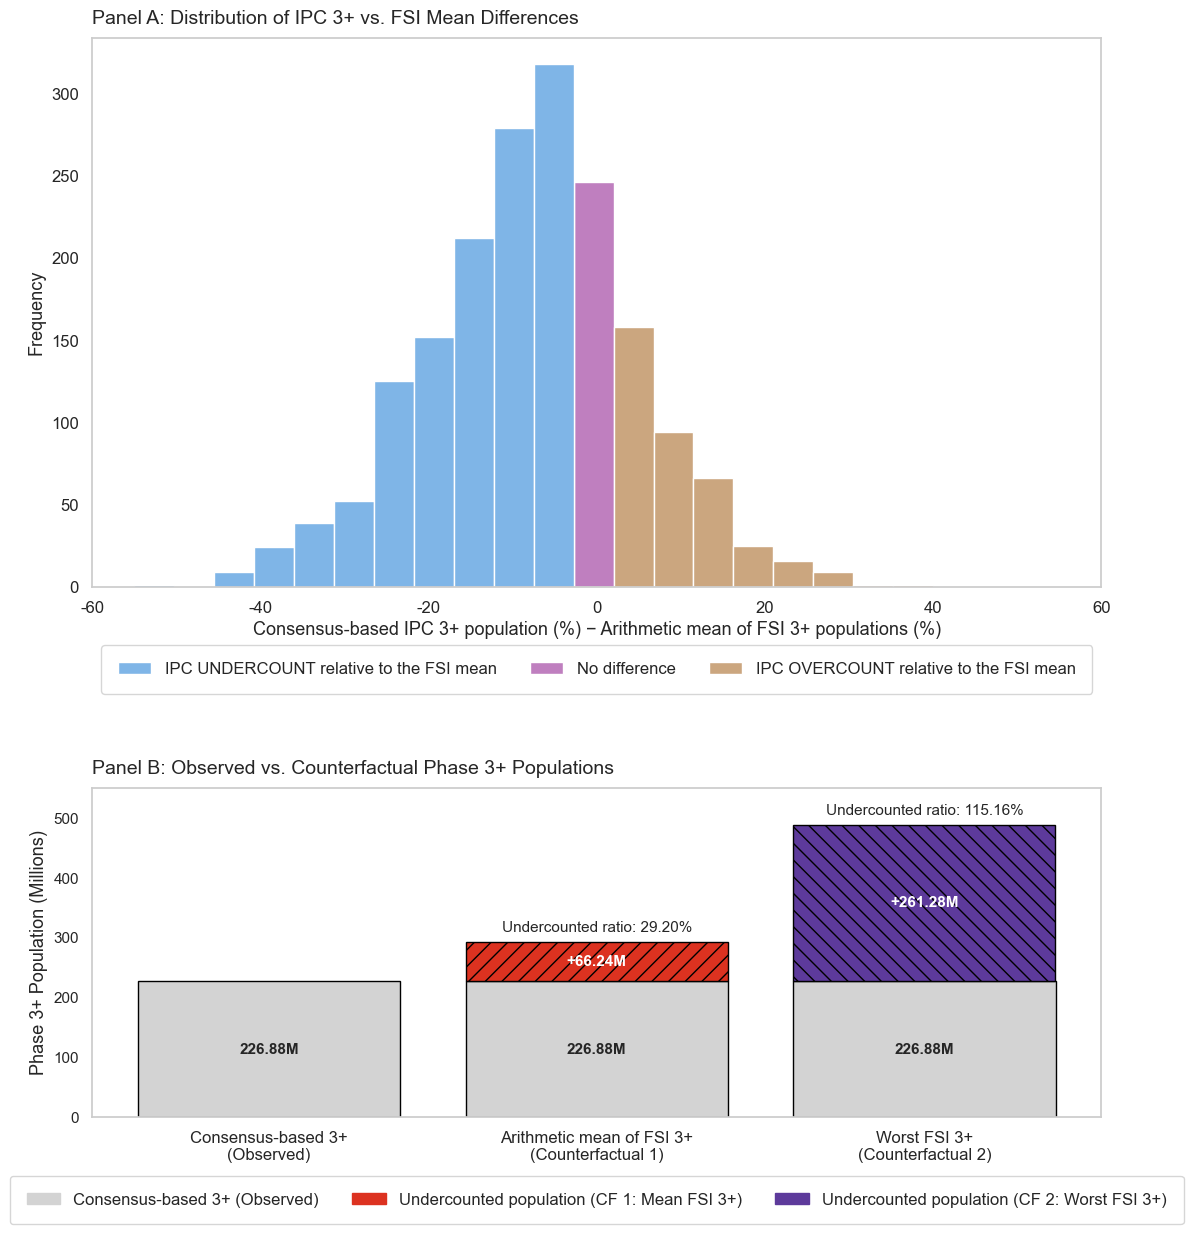

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =============================================================
# Setup: Style and Subplot Layout
# =============================================================

sns.set(style="whitegrid")

# Subplot layout
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12.5, 12.5), gridspec_kw={'height_ratios': [2.5, 1.5]}
)

# =============================================================
# Panel A: Histogram of Differences (IPC 3+ vs. FSI Mean)
# =============================================================

sns.histplot(
    df, x='diff', hue='obs-avg', ax=ax1,
    bins=len(set(sorted(df['diff'].unique().round(2)))),

    palette={
        'positive': '#994F00',
        'no difference': '#800080',
        'negative': '#006CD1'
    }
)

# Reorder legend
def capture_legend(ax):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    return handles, labels

handles, labels = capture_legend(ax1)
desired_order = ['negative', 'no difference', 'positive']
desired_labels = [
    'IPC UNDERCOUNT relative to the FSI mean',
    'No difference',
    'IPC OVERCOUNT relative to the FSI mean'
]
ordered_handles = [handles[labels.index(label)] for label in desired_order if label in labels]

ax1.legend(
    handles=ordered_handles, labels=desired_labels,
    bbox_to_anchor=(0.5, -0.15), ncol=3, borderpad=1,
    loc='center', fontsize=12, title=False
)

ax1.set_xlabel('Consensus-based IPC 3+ population (%) − Arithmetic mean of FSI 3+ populations (%)', fontsize=13)
ax1.set_ylabel('Frequency', fontsize=13)
ax1.tick_params(labelsize=12)
ax1.grid(False)

# Format x-axis as percentages
xticks = ax1.get_xticks()
ax1.set_xticks(xticks)
ax1.set_xticklabels([f"{x * 100:.0f}" for x in xticks], fontsize=12)

# =============================================================
# Panel B: Stacked Bar Plot (Observed vs. Undercounted, with CF1=Red, CF2=Purple)
# =============================================================

# =============================================================
# Panel B: Stacked Bar Plot (Observed vs. Undercounted, with CF1=Red, CF2=Purple, Hatched)
# =============================================================

# Take only 3 rows: observed, average, worst
stacked_df = results_df.iloc[0:3].copy()
stacked_df['observed'] = stacked_df['observed_3plusPop_Millions']
stacked_df['undercounted'] = stacked_df['Diff_3plusPop_Millions']

ax2.clear()

# Plot observed portion (gray, all three bars)
ax2.bar(
    range(len(stacked_df)), stacked_df['observed'],
    label='Observed 3+ population',
    color='lightgray', edgecolor='black'
)

# Colors and hatches for undercounted parts
undercount_colors = ['none', '#DC3220', '#5D3A9B']  # index 0 is "none"
undercount_hatches = [None, '//', '\\\\']  # red with //, purple with \\

# Plot undercounted portions stacked on top
for i, row in stacked_df.iterrows():
    if row['undercounted'] > 0:
        ax2.bar(
            i, row['undercounted'],
            bottom=row['observed'],
            color=undercount_colors[i],
            edgecolor='black',
            hatch=undercount_hatches[i]
        )

    # Annotate observed portion
    ax2.text(
        i, row['observed']/2,
        f"{row['observed']:.2f}M",
        ha='center', va='center', fontsize=11, fontweight='bold'
    )

    # Annotate undercounted portion
    if row['undercounted'] > 0:
        ax2.text(
            i, row['observed'] + row['undercounted']/2,
            f"+{row['undercounted']:.2f}M",
            ha='center', va='center', fontsize=11, fontweight='bold', color='white'
        )

        # Annotate ratio above full bar
        ax2.text(
            i, row['observed'] + row['undercounted'] + row['observed']*0.05,
            f"Undercounted ratio: {row['Ratio']:.2f}%",
            ha='center', va='bottom', fontsize=11
        )

# Axis formatting
ax2.set_ylabel('Phase 3+ Population (Millions)', fontsize=13)
ax2.set_xticks(range(len(stacked_df)))
ax2.set_xticklabels([
    'Consensus-based 3+\n(Observed)',
    'Arithmetic mean of FSI 3+\n(Counterfactual 1)',
    'Worst FSI 3+\n(Counterfactual 2)'
], fontsize=12)
ax2.set_ylim([0,550])

# Legend (same style approach as ax1, with hatches added)
ax2.legend(
    handles=[
        plt.Rectangle((0,0),1,1, color='lightgray', edgecolor='black',
                      label='Consensus-based 3+ (Observed)'),
        plt.Rectangle((0,0),1,1, color='#DC3220', edgecolor='black', hatch='//',
                      label='Undercounted population (CF 1: Mean FSI 3+)'),
        plt.Rectangle((0,0),1,1, color='#5D3A9B', edgecolor='black', hatch='\\',
                      label='Undercounted population (CF 2: Worst FSI 3+)')
    ],
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    borderpad=1,
    loc='center',
    fontsize=12,
    title=False
)

ax2.grid(False)

# =============================================================
# Final Formatting and Show Plot
# =============================================================

ax1.set_title('Panel A: Distribution of IPC 3+ vs. FSI Mean Differences', fontsize=14, loc='left', pad=10)
ax2.set_title('Panel B: Observed vs. Counterfactual Phase 3+ Populations', fontsize=14, loc='left', pad=10)

plt.tight_layout(h_pad=4)
plt.show()


# Figure 5. Relationship between the difference in Maximum (MAX) and Minimum (MIN) FSI implied 3+ population (%) and the absolute difference between the consensus-based 3+ population (%) and the arithmetic mean of FSI implied population (%).

1849


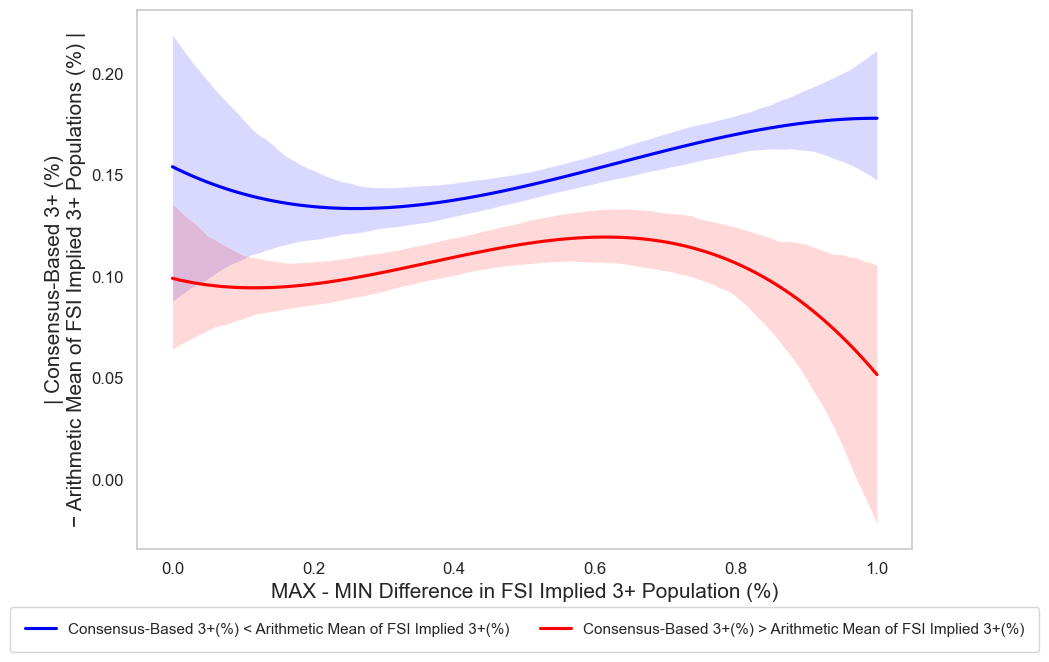

In [23]:
# =============================================================
# Setup: Create Figure and Filter Data
# =============================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Set Plot DF
df = ipc_df_sub.copy()
print(len(df))
# =============================================================
# Feature Engineering: Calculate Key Metrics
# =============================================================

# Y variable: difference between observed and average
df['diff'] = (df['phase3_plus_up'] - df['average3_up']).round(2)
df['diff_abs'] = (abs(df['phase3_plus_up'] - df['average3_up'])).round(2)

# X variables: spread and dispersion in FSI indicators
fsi_set = ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']
df['diff_minmax'] = (df[fsi_set].max(axis=1) - df[fsi_set].min(axis=1)).round(2)

# Label groups based on difference direction
df['obs-avg'] = np.where(df['diff'] > 0, 'positive', 'negative')
df['obs-avg'] = np.where(df['diff'] == 0, 'no difference', df['obs-avg'])

# =============================================================
# Polynomial Fit of Difference Magnitude vs. FSI Spread
# =============================================================

sns.regplot(
    data=df[df['obs-avg'] == 'negative'],
    x='diff_minmax', y='diff_abs',
    label='Consensus-Based 3+ (%) < Averaged FSI implied 3+ (%)',
    x_estimator=np.mean, x_ci=None, color='blue',
    scatter=False, order=3
)

sns.regplot(
    data=df[df['obs-avg'] == 'positive'],
    x='diff_minmax', y='diff_abs',
    label='Consensus-Based 3+ (%) > Averaged FSI Implied 3+ (%)',
    x_estimator=np.mean, x_ci=None, color='red',
    scatter=False, order=3
)

# =============================================================
# Plot formatting
# =============================================================

ax.set_ylabel(
    '| Consensus-Based 3+ (%)\n− Arithmetic Mean of FSI Implied 3+ Populations (%) |',
    fontsize=15
)
ax.set_xlabel('MAX - MIN Difference in FSI Implied 3+ Population (%)', fontsize=15)

for label in ax.get_xticklabels():
    label.set_fontsize(12)
for label in ax.get_yticklabels():
    label.set_fontsize(12)

ax.legend(
    [
        'Consensus-Based 3+(%) < Arithmetic Mean of FSI Implied 3+(%)',
        'Consensus-Based 3+(%) > Arithmetic Mean of FSI Implied 3+(%)'
    ],
    bbox_to_anchor=(0.5, -0.15),
    ncol=4, borderpad=1, loc='center',
    fontsize=11, title_fontsize=11
)

ax.grid(False)

# Tables & Figures in the Supplement Information

## Table A1: Description of the sample

In [24]:
# =============================================================
# Calculate population (in Millions) for each ample
# =============================================================

# Sample A
rounded_df['product'] = rounded_df['estimated_population'] * rounded_df['phase3plus_perc']

# Sample A'
rounded_df_nr['product'] = rounded_df_nr['estimated_population'] * rounded_df_nr['phase3plus_perc']

# Sample B
ipc_df_sub['product'] = ipc_df_sub['estimated_population'] * ipc_df_sub['phase3_plus']

# =============================================================
# Summary Statistics
# =============================================================

summary_data = {
    'Dataset': ['Sample A', "Sample A'", 'Sample B'],
    
    'Yearmon Min': [
        rounded_df['yearmon'].min(),
        rounded_df_nr['yearmon'].min(),
        ipc_df_sub['yearmon'].min()
    ],
    
    'Yearmon Max': [
        rounded_df['yearmon'].max(),
        rounded_df_nr['yearmon'].max(),
        ipc_df_sub['yearmon'].max()
    ],
    
    'Unique Countries': [
        rounded_df['country_name'].nunique(),
        rounded_df_nr['country_name'].nunique(),
        ipc_df_sub['country_name'].nunique()
    ],
    
    'Unique TWG Meetings': [
        rounded_df['index'].nunique(),
        rounded_df_nr['index'].nunique(),
        ipc_df_sub['index'].nunique()
    ],
    
    'Total Rows': [
        len(rounded_df),
        len(rounded_df_nr),
        len(ipc_df_sub)
    ],
    
    'Phase 3+ Count': [
        len(rounded_df[rounded_df['overall_phase'] >= 3]),
        len(rounded_df_nr[rounded_df_nr['overall_phase'] >= 3]),
        len(ipc_df_sub[ipc_df_sub['overall_phase'] >= 3])
    ],
    
    'Estimated Population (millions)': [
        rounded_df['estimated_population'].sum() / 1_000_000,
        rounded_df_nr['estimated_population'].sum() / 1_000_000,
        ipc_df_sub['estimated_population'].sum() / 1_000_000
    ],
    
    'Product (millions)': [
        rounded_df['product'].sum() / 1_000_000,
        rounded_df_nr['product'].sum() / 1_000_000,
        ipc_df_sub['product'].sum() / 1_000_000
    ]
}

#Summary df
summary_df = pd.DataFrame(summary_data)


summary_df

,Dataset,Yearmon Min,Yearmon Max,Unique Countries,Unique TWG Meetings,Total Rows,Phase 3+ Count,Estimated Population (millions),Product (millions)
0,Sample A,2017-01,2023-10,33,172,9394,6362,2803.965941,730.724744
1,Sample A',2017-01,2023-03,20,45,1496,490,461.169744,70.422047
2,Sample B,2020-10,2022-11,15,27,1849,1388,743.341640,226.876114


# Table A2. Summary Statistics – Sample A from Table A1

In [25]:
# =============================================================
# Summary Statistics: Sample A from Table A1 by Country
# =============================================================

# Compute 3+ Population (in millions)
rounded_df['product'] = rounded_df['estimated_population'] * rounded_df['phase3plus_perc']

# Group and summarize statistics by country
summary_by_country = rounded_df.groupby('country_name').agg(

    # ──────────────── Basic Information ────────────────
    unique_twg=('index', pd.Series.nunique),  # Unique TWG assessments per country
    total_classifications=('overall_phase', 'count'),  # Total number of area assessments
    total_population_millions=('estimated_population', lambda x: x.sum() / 1_000_000),

    # ──────────────── IPC Phase 3+ Metrics ────────────────
    threeplus_classifications=('overall_phase', lambda x: (x >= 3).sum()),
    threeplus_product_millions=('product', lambda x: x.sum() / 1_000_000),

    # ──────────────── Temporal Coverage ────────────────
    Yearmon_Max=('yearmon', 'max'),
    Yearmon_Min=('yearmon', 'min'),

    # ──────────────── Phase Mean & 3+ Share ────────────────
    average_Phase=('overall_phase', 'mean'),
    threeplus_perc=('phase3plus_perc', lambda x: x.mean() * 100)

).reset_index()

# Result df
summary_by_country


,country_name,unique_twg,total_classifications,total_population_millions,threeplus_classifications,threeplus_product_millions,Yearmon_Max,Yearmon_Min,average_Phase,threeplus_perc
0,Afghanistan,11,462,387.302149,420.0,146.330984,2023-10,2017-08,3.043290,38.326840
1,Angola,1,17,2.667790,16.0,1.315532,2021-06,2021-06,3.294118,55.294118
2,Bangladesh,1,17,38.236840,13.0,8.906604,2023-03,2023-03,2.764706,25.000000
3,Burundi,11,88,126.373513,10.0,16.530865,2023-09,2017-04,2.102273,12.977273
4,Central African Republic,9,500,48.057524,475.0,19.090511,2023-09,2018-03,3.106000,42.966000
5,"Congo, DRC",7,1033,593.617515,668.0,156.582008,2023-07,2018-08,2.692159,24.884802
6,Djibouti,3,45,3.480493,22.0,0.536925,2023-03,2020-10,2.488889,23.111111
7,Dominican Republic,1,32,10.621938,6.0,1.552881,2022-10,2022-10,2.156250,15.562500
8,El Salvador,3,25,10.635105,1.0,0.898123,2020-11,2017-11,1.760000,7.600000
9,Eswatini,8,57,8.742808,31.0,1.825193,2023-06,2017-07,2.491228,20.614035


# Table A3. Summary Statistics – Sample B from Table A1 (country level)

In [26]:
# =============================================================
# Summary Statistics: IPC Sample B from Table A1 by Country
# =============================================================

# Compute 3+ Population (in millions)
ipc_df_sub['product'] = ipc_df_sub['estimated_population'] * ipc_df_sub['phase3_plus']

# Group and summarize statistics by country
summary_by_country = ipc_df_sub.groupby('country_name').agg(

    # ──────────────── Basic Information ────────────────
    unique_twg=('index', pd.Series.nunique),  # Unique TWG assessments per country
    unique_classifications=('overall_phase', 'count'),  # Total number of area assessments
    total_population_millions=('estimated_population', lambda x: x.sum() / 1_000_000),

    # ──────────────── IPC Phase 3+ ────────────────
    threeplus_classifications=('overall_phase', lambda x: (x >= 3).sum()),
    threeplus_millions=('product', lambda x: x.sum() / 1_000_000),

    # ──────────────── Temporal Coverage ────────────────
    Yearmon_Max=('yearmon', 'max'),
    Yearmon_Min=('yearmon', 'min'),

    # ──────────────── Mean IPC Phase & Share in Phase 3+ ────────────────
    average_Phase=('overall_phase', 'mean'),
    threeplus_perc=('phase3_plus', lambda x: x.mean() * 100),

    # ──────────────── FSI-Implied 3+ Population Share ────────────────
    fcs_threeplus_perc=('FCS_3plus_up', lambda x: x.mean() * 100),
    rcsi_threeplus_perc=('rCSI_3plus_up', lambda x: x.mean() * 100),
    hhs_threeplus_perc=('hhs_3plus_up', lambda x: x.mean() * 100),
    lcs_threeplus_perc=('lcs_3plus_up', lambda x: x.mean() * 100),
    hdds_threeplus_perc=('hdds_3plus_up', lambda x: x.mean() * 100)

).reset_index()

#result df
summary_by_country


,country_name,unique_twg,unique_classifications,total_population_millions,threeplus_classifications,threeplus_millions,Yearmon_Max,Yearmon_Min,average_Phase,threeplus_perc,fcs_threeplus_perc,rcsi_threeplus_perc,hhs_threeplus_perc,lcs_threeplus_perc,hdds_threeplus_perc
0,Afghanistan,4,180,169.889180,176,72.507670,2022-09,2021-03,3.238889,42.027778,79.333333,21.583333,38.888889,59.027778,51.218750
1,Central African Republic,3,191,15.196704,191,6.351790,2022-09,2021-04,3.115183,44.083770,45.793651,28.121693,79.712042,76.073298,NaN
2,"Congo, DRC",3,529,299.173718,346,80.277082,2022-08,2021-02,2.674858,25.406427,57.100760,16.891892,43.058659,45.180608,38.373288
3,Djibouti,1,15,1.181675,6,0.131997,2022-03,2022-03,2.400000,19.333333,32.666667,4.000000,NaN,12.000000,24.000000
4,Ethiopia,1,13,8.810267,13,5.429058,2021-05,2021-05,3.538462,60.000000,72.307692,56.538462,60.769231,91.538462,NaN
5,Guatemala,1,22,17.357886,14,3.927271,2022-03,2022-03,2.636364,22.318182,26.363636,9.545455,NaN,43.181818,NaN
6,Haiti,1,32,9.906757,32,4.333426,2021-09,2021-09,3.156250,43.750000,54.531250,27.031250,27.968750,52.500000,70.625000
7,Kenya,2,46,30.566448,10,3.573048,2021-09,2021-02,2.086957,12.173913,30.869565,9.456522,NaN,16.195652,NaN
8,Lebanon,1,52,5.364000,41,1.985750,2022-09,2022-09,2.788462,37.307692,50.673077,46.923077,NaN,72.307692,93.846154
9,Madagascar,3,47,14.164102,39,5.046837,2022-11,2021-05,2.936170,36.702128,73.510638,49.361702,36.808511,47.021277,34.893617


# Table A4. Summary Statistics – Sample B from Table A1 (country by round)

In [27]:
# =============================================================
# Summary Statistics by TWG Round and FSI Combination Group
# =============================================================

# Compute 3+ Population (in millions)
ipc_df_sub["product"] = ipc_df_sub["estimated_population"] * ipc_df_sub["phase3_plus"]

# Define FSI combination groups
ipc_df_sub['FSI_group'] = ipc_df_sub['FSI_combination'].map({
    'FCS-RCSI-HHS-LCS-HDDS': 'Group 1',
    'FCS-RCSI-HHS-LCS':      'Group 2',
    'FCS-RCSI-LCS-HDDS':     'Group 3',
    'FCS-RCSI-LCS':          'Group 4'
})

# Group and summarize by FSI group and TWG round (index)
summary_by_country_round = (
    ipc_df_sub
    .groupby(["FSI_group", "FSI_combination", "index"])
    .agg(

        # ────────────── Basic Information ──────────────
        unique_classifications=('overall_phase', 'count'),
        total_population_millions=('estimated_population', lambda x: x.sum() / 1_000_000),
        
        # ──────────────  IPC Phase 3+ ──────────────
        threeplus_classifications=('overall_phase', lambda x: (x >= 3).sum()),
        threeplus_millions=('product', lambda x: x.sum() / 1_000_000),

        # ────────────── Temporal Coverage ──────────────
        Yearmon_Min=('yearmon', 'min'),
        Yearmon_Max=('yearmon', 'max'),

        # ────────────── Mean Phase & FSI 3+ Shares ──────────────
        average_phase=('overall_phase', 'mean'),
        threeplus_perc=('phase3_plus', lambda x: x.mean() * 100),
        fcs_threeplus_perc=('FCS_3plus_up', lambda x: x.mean() * 100),
        rcsi_threeplus_perc=('rCSI_3plus_up', lambda x: x.mean() * 100),
        hhs_threeplus_perc=('hhs_3plus_up', lambda x: x.mean() * 100),
        lcs_threeplus_perc=('lcs_3plus_up', lambda x: x.mean() * 100),
        hdd_threeplus_perc=('hdds_3plus_up', lambda x: x.mean() * 100)
    )
    .reset_index()
)

# Result DF
summary_by_country_round.sort_values(by=['FSI_group', 'index'])


,FSI_group,FSI_combination,index,unique_classifications,total_population_millions,threeplus_classifications,threeplus_millions,Yearmon_Min,Yearmon_Max,average_phase,threeplus_perc,fcs_threeplus_perc,rcsi_threeplus_perc,hhs_threeplus_perc,lcs_threeplus_perc,hdd_threeplus_perc
0,Group 1,FCS-RCSI-HHS-LCS-HDDS,"(Afghanistan, 2021-03)",45,34.682027,41,12.030415,2021-03,2021-03,3.022222,34.333333,76.555556,15.333333,31.000000,51.777778,33.222222
1,Group 1,FCS-RCSI-HHS-LCS-HDDS,"(Afghanistan, 2021-09)",45,45.644122,45,21.516760,2021-09,2021-09,3.466667,46.666667,75.000000,24.888889,38.777778,58.000000,68.888889
2,Group 1,FCS-RCSI-HHS-LCS-HDDS,"(Afghanistan, 2022-03)",45,42.433152,45,20.070888,2022-03,2022-03,3.400000,46.666667,89.555556,25.555556,51.777778,67.777778,56.000000
3,Group 1,FCS-RCSI-HHS-LCS-HDDS,"(Afghanistan, 2022-09)",45,47.129879,45,18.889607,2022-09,2022-09,3.066667,40.444444,76.222222,20.555556,34.000000,58.555556,43.200000
4,Group 1,FCS-RCSI-HHS-LCS-HDDS,"(Congo, DRC, 2021-09)",179,102.259069,123,27.020164,2021-09,2021-09,2.709497,25.502793,60.113636,17.528409,41.333333,46.931818,47.259259
5,Group 1,FCS-RCSI-HHS-LCS-HDDS,"(Haiti, 2021-09)",32,9.906757,32,4.333426,2021-09,2021-09,3.156250,43.750000,54.531250,27.031250,27.968750,52.500000,70.625000
6,Group 1,FCS-RCSI-HHS-LCS-HDDS,"(Madagascar, 2021-05)",10,2.683420,8,1.137633,2021-05,2021-05,3.300000,44.000000,76.500000,55.500000,62.000000,72.500000,19.000000
7,Group 1,FCS-RCSI-HHS-LCS-HDDS,"(Madagascar, 2022-04)",16,5.250604,12,1.684129,2022-04,2022-04,2.750000,32.812500,70.312500,58.750000,38.125000,46.875000,44.375000
8,Group 1,FCS-RCSI-HHS-LCS-HDDS,"(Madagascar, 2022-11)",21,6.230078,19,2.225075,2022-11,2022-11,2.904762,36.190476,74.523810,39.285714,23.809524,35.000000,35.238095
9,Group 1,FCS-RCSI-HHS-LCS-HDDS,"(South Sudan, 2022-10)",77,12.374205,75,6.633736,2022-10,2022-10,3.389610,52.857143,78.421053,28.684211,72.236842,64.144737,64.078947


# FIgure A1. Correlation Matrix: FSI implied 3+ popultion (%) for sample with All-5-FSI

All-5-FSI Sample(Dropped Missing Val): 600


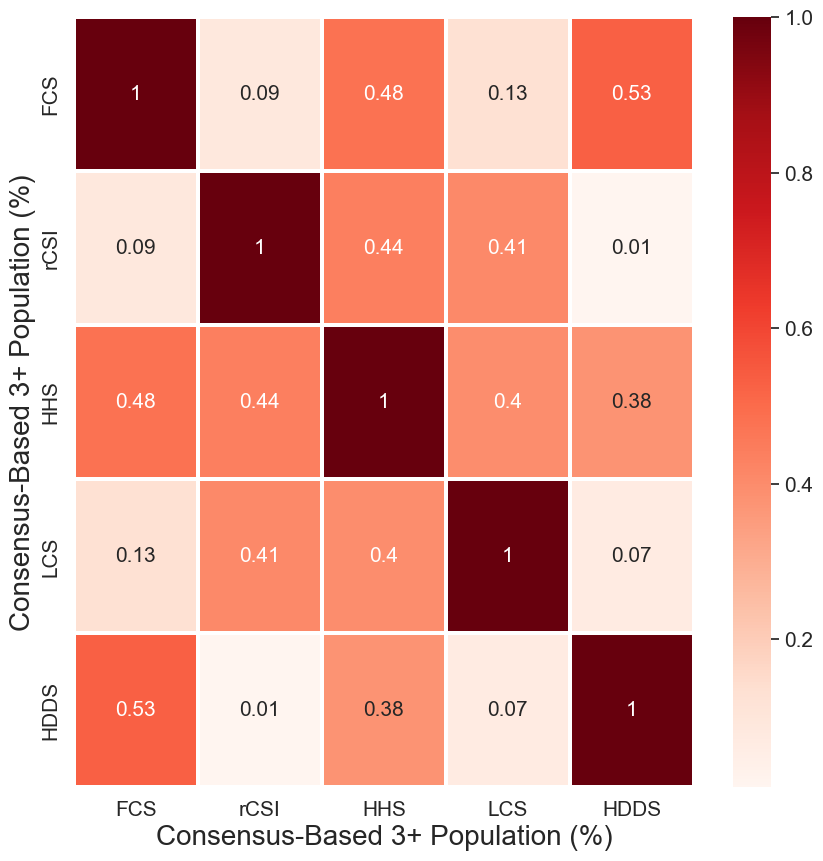

In [28]:
# =============================================================
# Correlation heatmap of FSI-nased Phase 3+ Estimates (All-5 Sample)
# =============================================================

fig, ax = plt.subplots(1, figsize=(10, 10))

# Filter to only include all-5 FSI combination sample
df = ipc_df_sub.copy()
plotdf = df[df['FSI_combination'].isin(['FCS-RCSI-HHS-LCS-HDDS'])] #All-5-FSI

# Select FSI indicator columns (excluding first column ending with '_up')
fsi_columns = [col for col in plotdf.columns if col.endswith('_up')][1:6]
plotdf = plotdf[fsi_columns + ['country']]

# Compute Pearson Corr
corr_matrix = plotdf.dropna().corr(method='pearson').round(2)
print('All-5-FSI Sample(Dropped Missing Val):', len(plotdf.dropna()))

# Create heatmap
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    annot_kws={'size': 15},
    linewidth=2,
    cmap='Reds',
    yticklabels=['FCS', 'rCSI', 'HHS', 'LCS', 'HDDS'],
    xticklabels=['FCS', 'rCSI', 'HHS', 'LCS', 'HDDS'],
    ax=ax
)

# Axis
ax.set_xlabel('Consensus-Based 3+ Population (%)', fontsize=20)
ax.set_ylabel('Consensus-Based 3+ Population (%)', fontsize=20)

# colorbar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

# Tick label
for label in ax.get_xticklabels():
    label.set_fontsize(15)
for label in ax.get_yticklabels():
    label.set_fontsize(15)


# Figure A2. Year x Round specific observed and estimated distributions of IPC assessments defined by the proportion of population in phase 3+ for Afghanistan

*analysis running for: ('Afghanistan', '2019-08')
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
*analysis running for: ('Afghanistan', '2020-04')
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
*analysis running for: ('Afghanistan', '2020-08')
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
*analysis running for: ('Afghanistan', '2021-03')
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
*analysis running for: ('Afghanistan', '2021-09')
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
*analysis running for: ('Afghanistan', '2022-03')
Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
*analysis running for: ('Afghanistan', '2022-09')
Excluding midpoint: 0.150


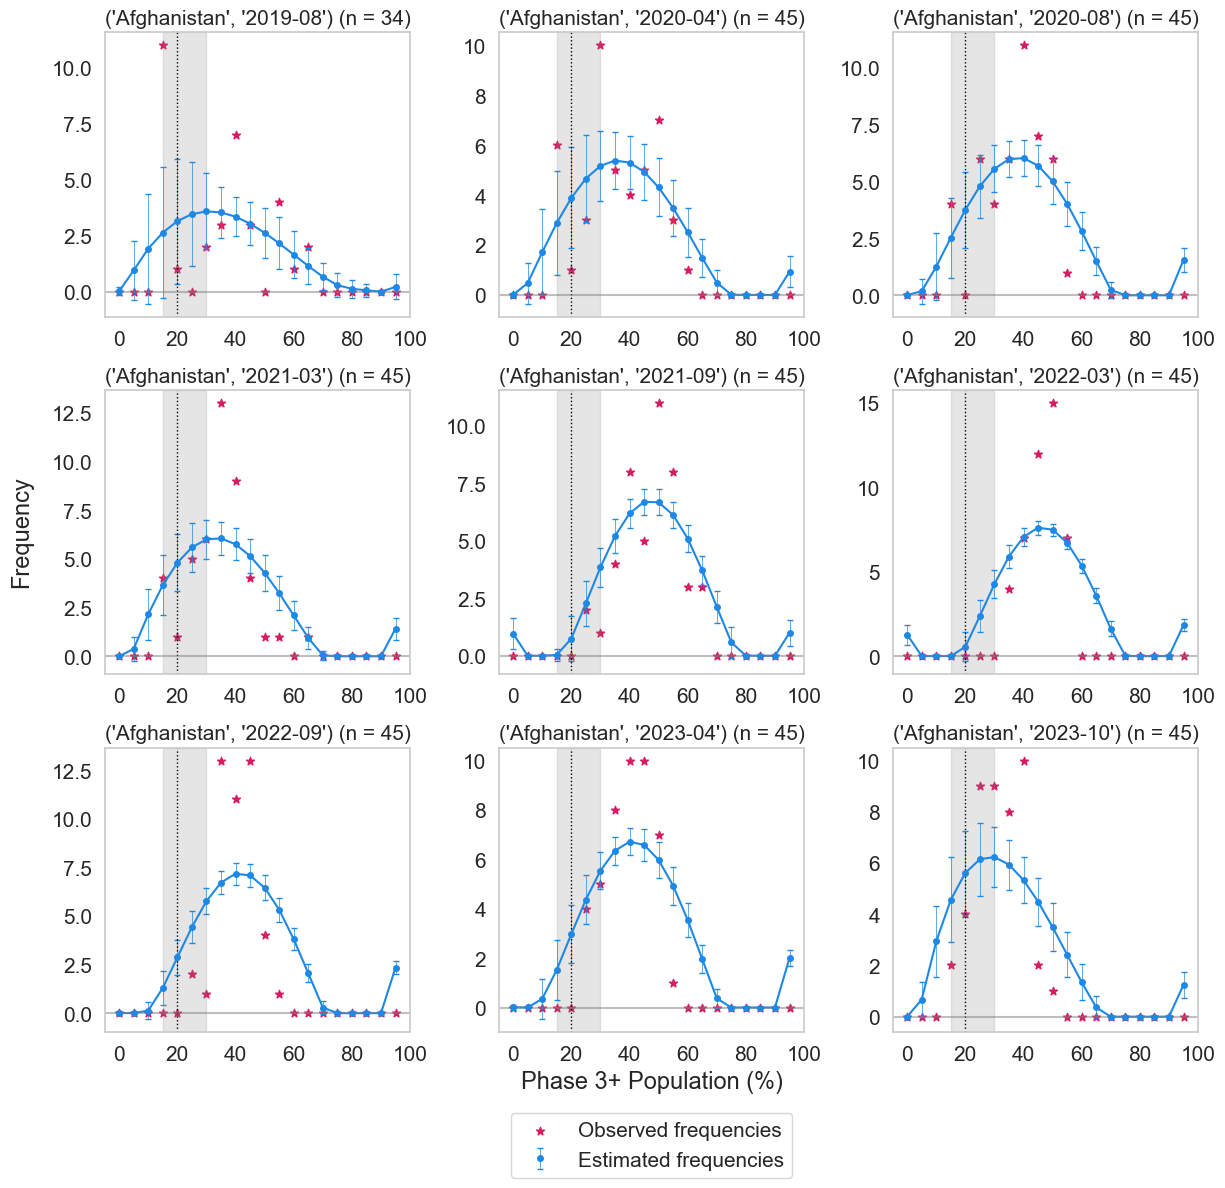

In [29]:
# =============================================================
# Set Bunching Analyis Parameters
# =============================================================
var = 'phase3plus_perc'
countries = sorted(rounded_df[(rounded_df['country_name'] == 'Afghanistan')]['index'].unique())[2:]
binwidth = 0.05
poly_degree = 4
num_simulations = 500
exclude_index = []

# =============================================================
# Set Up Subplots
# =============================================================
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
agg = []

# =============================================================
# Iterate by country
# =============================================================
for i, c in enumerate(countries):
    sub_df = rounded_df[(rounded_df['index'] == c)]
    data_series = sub_df[var].dropna()
    if data_series.empty:
        continue

    # Initialize Bunching Analyzer
    sim = BunchingAnalysis(data_series, binwidth=binwidth, poly_degree=poly_degree)
    
    # Run Simulation 1
    print('*analysis running for:', c)
    coeff_matrix, mean_coeffs, se_coeffs = sim.scenario1(num_simulations=num_simulations)

    # ---------------------------------------------------------
    # Plot Setup
    # ---------------------------------------------------------
    row, col = i // 3, i % 3
    ax = axes[row, col]

    # Plot observed data
    counts, _ = np.histogram(data_series.round(2), bins=sim.bins.round(2))
    ax.scatter(sim.midpoints - binwidth / 2, counts, color='#D81B60', marker='*')

    # Plot estimated data with error bars (2SE)
    ax.errorbar(sim.midpoints - binwidth / 2, mean_coeffs, yerr=se_coeffs * 2,
                fmt='o', color='#1E88E5', ecolor='#1E88E5', elinewidth=0.5, capsize=2, markersize=4)
    
    # Add legend
    if (row == 2) and (col == 1):
        ax.legend(['Observed frequencies', 'Estimated frequencies'], 
                  bbox_to_anchor=(0.5, -0.4), loc="center", ncol=1, fontsize=15)
        ax.set_xlabel('Phase 3+ Population (%)', fontsize=17)
        
    # Line plot for estimated values
    ax.plot(sim.midpoints - binwidth / 2, mean_coeffs, color='#1E88E5')
    
    # Others
    ax.axvline(x=0.20, color='black', linestyle=':', linewidth=1)
    ax.axvspan(0.15, 0.30, color='gray', alpha=0.2)
    ax.axhline(y=0.0, color='gray', alpha=0.5)

    ax.set_title(f'{c} (n = {len(sub_df)})', fontsize=15)
    ax.set_xticks(np.arange(0, 1.05, 0.2))
    ax.set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)])
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(False)

    # ---------------------------------------------------------
    # Aggregate diff bin exclusion scenario results
    # ---------------------------------------------------------
    agg_df = pd.DataFrame({
        'bin': sim.midpoints - binwidth / 2,
        'observed': counts,
        'estimated': mean_coeffs
    })
    agg_df['excess_mass'] = (agg_df['observed'] - agg_df['estimated']) / agg_df['estimated']
    agg.append(agg_df)

# =============================================================
# Show Result
# =============================================================
plt.tight_layout()
fig.text(-0.01, 0.55, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=17)
plt.show()


# Figure A3. Comparisons of distributions of IPC assessments defined by proportion of population in phase 3+ (observed vs counterfactuals)

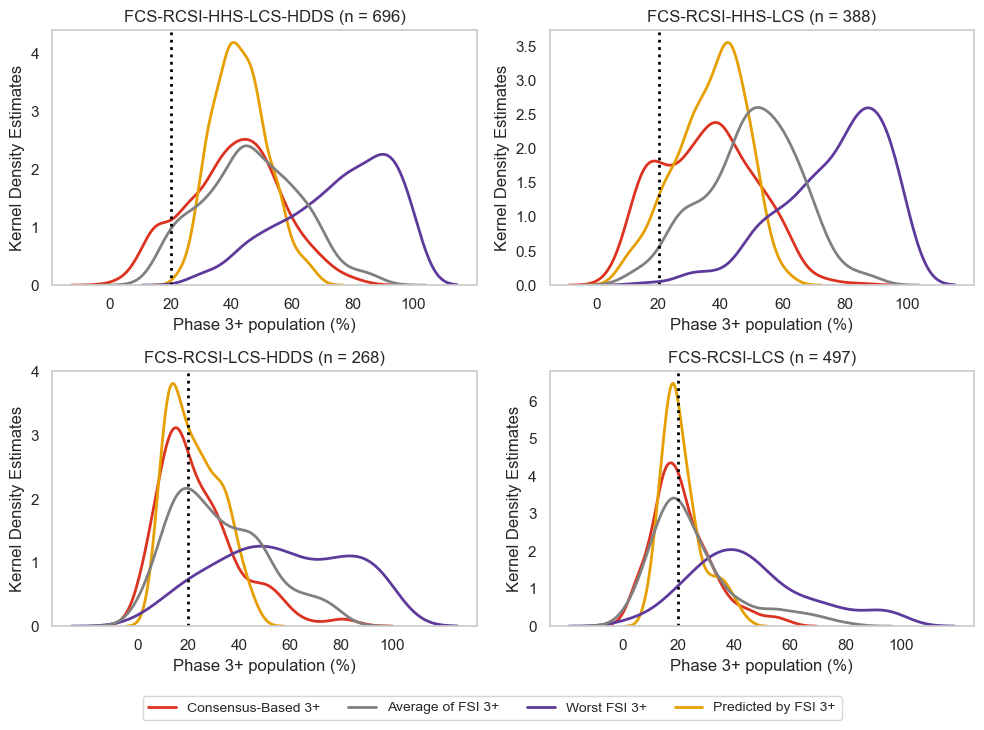

In [30]:
# ====================================================
# KDE Plots of Phase 3+ Estimates by FSI Combinations
# ====================================================

# Unique combinations to loop 
unique_combinations = [
    'FCS-RCSI-HHS-LCS-HDDS',
    'FCS-RCSI-HHS-LCS',
    'FCS-RCSI-LCS-HDDS',
    'FCS-RCSI-LCS'
]

# Create subplot grid
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

# Iterate through FSI combinations
for i, g in enumerate(unique_combinations):
    row, col = i // 2, i % 2
    subset = ipc_df_sub[ipc_df_sub['FSI_combination'] == g]

    sns.kdeplot(subset['phase3_plus'], ax=ax[row, col], linewidth=2, color='#DC3220', label='Consensus-Based 3+')
    sns.kdeplot(subset['fsi_predicted'], ax=ax[row, col], linewidth=2, color='#E69F00', label='Predicted by FSI 3+')
    sns.kdeplot(subset['worst_fsi'], ax=ax[row, col], linewidth=2, color='#5D3A9B', label='Worst FSI 3+')
    sns.kdeplot(subset['average_3plus'], ax=ax[row, col], linewidth=2, color='gray', label='Average of FSI 3+')

    ax[row, col].set_title(f"{g} (n = {len(subset)})")
    ax[row, col].set_xlabel('Phase 3+ population (%)')
    ax[row, col].set_ylabel('Kernel Density Estimates')
    ax[row, col].axvline(x=0.2, color='black', linewidth=2, linestyle=':')
    ax[row, col].set_xticks(np.arange(0, 1.05, 0.2))
    ax[row, col].set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)])
    ax[row, col].grid(False)

# Remove unused subplot
for i in range(len(unique_combinations), 4):
    fig.delaxes(ax[i // 2, i % 2])

plt.tight_layout()

# Extract handles from the first subplot
handles, labels = ax[0, 0].get_legend_handles_labels()

# Define order of labels
re_order = [
    'Consensus-Based 3+',
    'Average of FSI 3+',
    'Worst FSI 3+',
    'Predicted by FSI 3+'
]
ordered_handles = [handles[labels.index(label)] for label in re_order]

# Global legend
fig.legend(
    ordered_handles,
    re_order,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    fontsize=10
)

plt.show()


# Figure A4: Comparisons of cumulative distributions of IPC assessments defined by proportion of population in phase 3+ (Observed vs Counterfactual)

In [31]:
# =============================================================
# Run BD Test (First Stochastic Dominance Consensus-based vs. Counterfactual)
# =============================================================
import pysdtest

def run_sd_by_group(df, convergence, counter, order=1, resampling='paired_bootstrap', nboot=1000, ngrid=200):
    rows = []
    for g, gdf in df.dropna(subset=[convergence, counter]).groupby('FSI_combination'):
        x = gdf[counter].to_numpy()      # consensus_based
        y = gdf[convergence].to_numpy()      # counterfactual
        test = pysdtest.test_sd(x, y, ngrid=ngrid, s=order,
                                resampling=resampling, nboot=nboot)
        print(g)
        test.testing()
        rows.append({"FSI_combination": g,
                     "n": len(gdf),
                     "compare": f"{counter} vs {convergence}",
                     "order": order,
                     "resampling": resampling})
    return pd.DataFrame(rows), x


unique_combinations = ['FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-HHS-LCS', 'FCS-RCSI-LCS-HDDS', 'FCS-RCSI-LCS']

# Implementing BD test (Consensus > Counterfactual)
res_avg = run_sd_by_group(ipc_df_sub[ipc_df_sub['FSI_combination'].isin(unique_combinations)], convergence='phase3_plus', counter='average_3plus', order=1)
res_worst = run_sd_by_group(ipc_df_sub[ipc_df_sub['FSI_combination'].isin(unique_combinations)], convergence='phase3_plus', counter='worst_fsi',     order=1)

FCS-RCSI-HHS-LCS

#-------------------------------------------#
Testing for Stochastic Dominance 

* H0 : sample1  First Order SD sample2
* Resampling method 	: paired_bootstrap


* # of (sample1) 		 =    388 
* # of (sample2) 		 =    388

* # of bootstrapping:  1000
#-------------------------------------------#

* SD order 		 =      1 
* # of grid points 	 =    200

#-------------------------------------------#

* Test Result *

* Test statistic = 0.0000
* p-value 	 = 1.0000

#-------------------------------------------#

* Time elapsed :  8.40 Sec
FCS-RCSI-HHS-LCS-HDDS

#-------------------------------------------#
Testing for Stochastic Dominance 

* H0 : sample1  First Order SD sample2
* Resampling method 	: paired_bootstrap


* # of (sample1) 		 =    687 
* # of (sample2) 		 =    687

* # of bootstrapping:  1000
#-------------------------------------------#

* SD order 		 =      1 
* # of grid points 	 =    200

#-------------------------------------------#

* Test Result *

* Tes

In [32]:
# Implementing Reciprocal - BD test (Consensus < Counterfactual)
res_avg = run_sd_by_group(ipc_df_sub[ipc_df_sub['FSI_combination'].isin(unique_combinations)], convergence='average_3plus', counter='phase3_plus', order=1)
res_worst = run_sd_by_group(ipc_df_sub[ipc_df_sub['FSI_combination'].isin(unique_combinations)], convergence='worst_fsi', counter='phase3_plus',     order=1)

FCS-RCSI-HHS-LCS

#-------------------------------------------#
Testing for Stochastic Dominance 

* H0 : sample1  First Order SD sample2
* Resampling method 	: paired_bootstrap


* # of (sample1) 		 =    388 
* # of (sample2) 		 =    388

* # of bootstrapping:  1000
#-------------------------------------------#

* SD order 		 =      1 
* # of grid points 	 =    200

#-------------------------------------------#

* Test Result *

* Test statistic = 5.8514
* p-value 	 = 0.0000

#-------------------------------------------#

* Time elapsed :  8.23 Sec
FCS-RCSI-HHS-LCS-HDDS

#-------------------------------------------#
Testing for Stochastic Dominance 

* H0 : sample1  First Order SD sample2
* Resampling method 	: paired_bootstrap


* # of (sample1) 		 =    687 
* # of (sample2) 		 =    687

* # of bootstrapping:  1000
#-------------------------------------------#

* SD order 		 =      1 
* # of grid points 	 =    200

#-------------------------------------------#

* Test Result *

* Tes

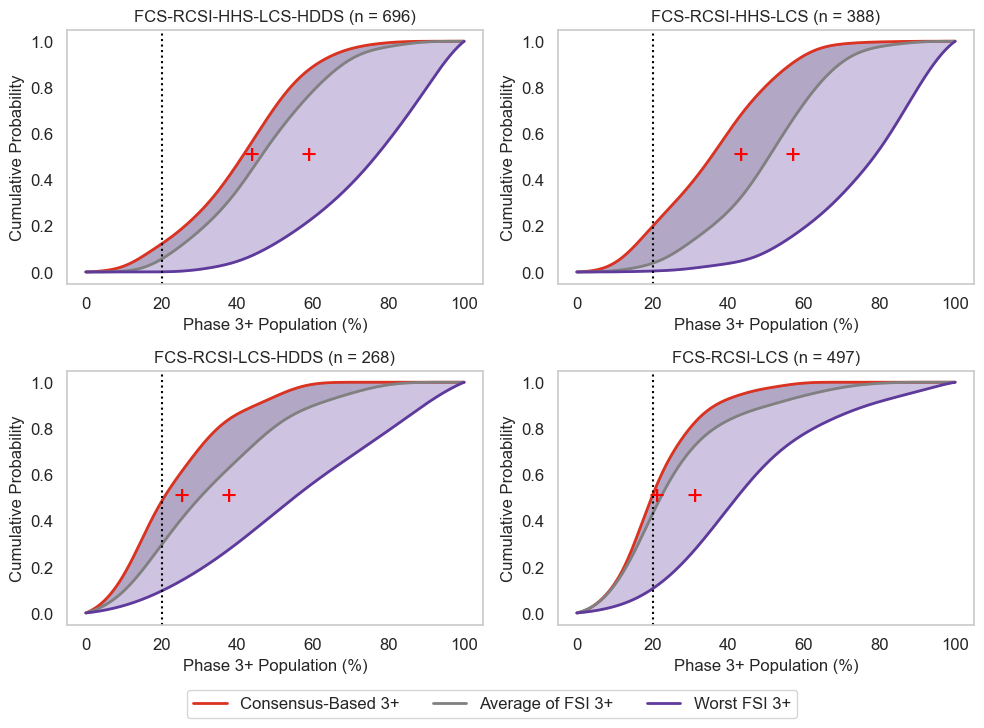

In [33]:
# Plot Set-up
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

unique_combinations = ['FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-HHS-LCS', 'FCS-RCSI-LCS-HDDS', 'FCS-RCSI-LCS']
x = np.linspace(0, 1, 1000)

# For storing handles for global legend
legend_handles = []

for i, g in enumerate(unique_combinations):
    row, col = i // 2, i % 2
    plot_df_org = ipc_df_sub[ipc_df_sub['FSI_combination'] == g]
    plot_df = plot_df_org.dropna(subset=['phase3_plus', 'worst_fsi', 'average_3plus'])
    
    # KDE and CDF
    kde_avg = gaussian_kde(plot_df['average_3plus'])
    kde_worst = gaussian_kde(plot_df['worst_fsi'])
    kde_3plus = gaussian_kde(plot_df['phase3_plus'])

    cdf_avg = np.cumsum(kde_avg(x)); cdf_avg /= cdf_avg[-1]
    cdf_worst = np.cumsum(kde_worst(x)); cdf_worst /= cdf_worst[-1]
    cdf_3plus = np.cumsum(kde_3plus(x)); cdf_3plus /= cdf_3plus[-1]

    # Plot
    h1, = ax[row, col].plot(x, cdf_3plus, label='Consensus-Based 3+', color='#DC3220', linewidth=2)
    h2, = ax[row, col].plot(x, cdf_avg, label='Average FSI 3+', color='gray', linewidth=2)
    h3, = ax[row, col].plot(x, cdf_worst, label='Worst FSI 3+', color='#5D3A9B', linewidth=2)

    if i == 0:
        legend_handles = [h1, h2, h3]  # Save handles for global legend

    # Annotated '+' markers at CDF 0.5
    x_avg = np.interp(0.5, cdf_avg, x)
    x_3plus = np.interp(0.5, cdf_3plus, x)
    x_worst = np.interp(0.5, cdf_worst, x)

    avg_pos = (x_avg + x_3plus) / 2
    worst_pos = (x_worst + x_3plus) / 2

    ax[row, col].annotate('+', xy=(avg_pos, 0.5), fontsize=20, ha='center', va='center', color='red')
    ax[row, col].annotate('+', xy=(worst_pos, 0.5), fontsize=20, ha='center', va='center', color='red')

    ax[row, col].fill_between(x, cdf_avg, cdf_3plus, where=(cdf_3plus >= cdf_avg), color='gray', alpha=0.3)
    ax[row, col].fill_between(x, cdf_worst, cdf_3plus, where=(cdf_3plus >= cdf_worst), color='#5D3A9B', alpha=0.3)

    ax[row, col].set_title(f"{g} (n = {len(plot_df_org)})", fontsize=12)
    ax[row, col].set_xlabel('Phase 3+ Population (%)', fontsize=12)
    ax[row, col].set_ylabel('Cumulative Probability', fontsize=12)

    ax[row, col].set_xticks(np.arange(0, 1.05, 0.2))
    ax[row, col].set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)])

    ax[row, col].axvline(x=0.2, color='black', linestyle=':')

    ax[row, col].tick_params(axis='x', labelsize=12)
    ax[row, col].tick_params(axis='y', labelsize=12)
    ax[row, col].grid(False)

plt.tight_layout()
fig.legend(legend_handles, ['Consensus-Based 3+', 'Average of FSI 3+', 'Worst FSI 3+'],
           loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)
plt.show()


# Figure A5. IPC Undercount and Overcount relative to FSI mean by country

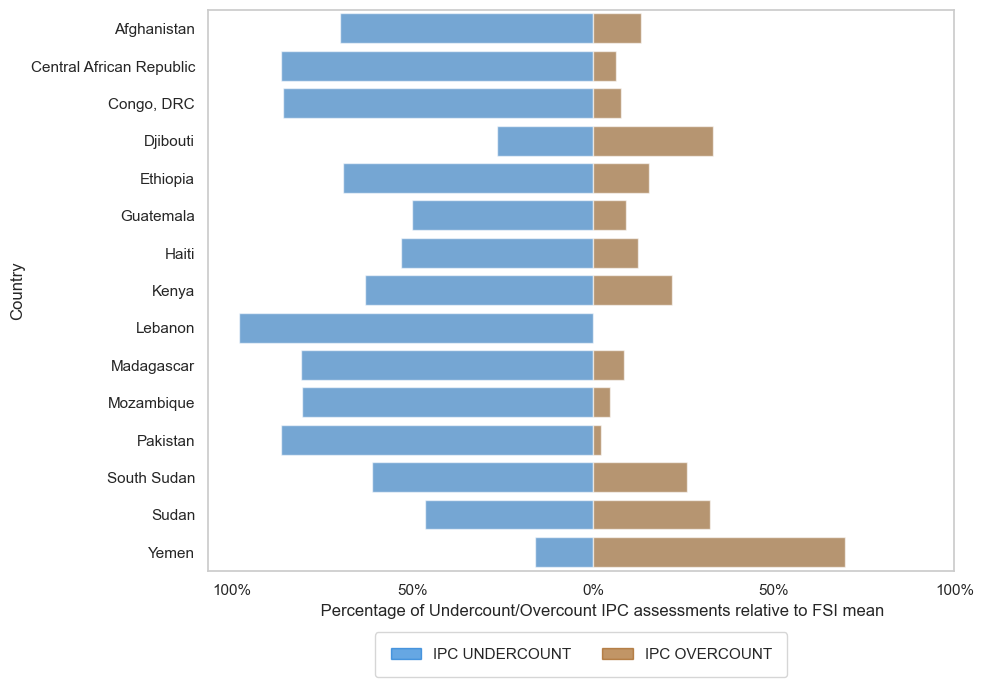

In [34]:
# =============================================================
# Data Preparation Figure A5 and A6
# =============================================================
df = ipc_df_sub[ipc_df_sub['FSI_combination'] != 'FCS-RCSI-HHS-HDDS'].copy()
df['country_name'] = df['country_name'].replace({'Congo':'DR Congo'})
# Define y-axis
df['diff']     = (df['phase3_plus_up'] - df['average3_up']).round(2)
df['diff_abs'] = (abs(df['diff'])).round(2)

# Define x-axis components
fsi_set = [
    'FCS_3plus_up',
    'rCSI_3plus_up',
    'hhs_3plus_up',
    'lcs_3plus_up',
    'hdds_3plus_up'
]

df['diff_minmax'] = (df[fsi_set].max(axis=1) - df[fsi_set].min(axis=1)).round(2)
df['fi_sd'] = df[fsi_set].std(axis=1).round(2)

# Classify based on difference direction
df['obs-avg'] = np.where(df['diff'] > 0, 'positive', 'negative')
df['obs-avg'] = np.where(df['diff'] == 0, 'no difference', df['obs-avg'])

# =============================================================
# Aggregation
# =============================================================
agg_level = 'country_name'  # or 'index' for Country x Round

df_conserve_count_df = (
    df.groupby(agg_level)['obs-avg']
    .value_counts(normalize=True)
    .reset_index(name='normalized_counts')
)

df_conserve_count_df = df_conserve_count_df[df_conserve_count_df['obs-avg'] != 'no difference']
df_conserve_count_df['normalized_counts'] = np.where(
    df_conserve_count_df['obs-avg'] == 'negative',
    -df_conserve_count_df['normalized_counts'],
    df_conserve_count_df['normalized_counts']
)

wide_df = (
    df_conserve_count_df
    .pivot(index=agg_level, columns='obs-avg', values='normalized_counts')
    .reset_index()
    .rename(columns={'negative': 'undercount', 'positive': 'overcount'})
)

# =============================================================
# Plot
# =============================================================
fig, ax = plt.subplots(figsize=(10, 7))

# Undercount bars
sns.barplot(
    x='undercount',
    y=agg_level,
    data=wide_df,
    order=sorted(wide_df[agg_level].unique()),
    color='#006CD1',
    alpha=0.6,
    ax=ax
)

# Overcount bars
sns.barplot(
    x='overcount',
    y=agg_level,
    data=wide_df,
    order=sorted(wide_df[agg_level].unique()),
    color='#994F00',
    alpha=0.6,
    ax=ax
)

# legend
undercount_patch = mpatches.Patch(color='#006CD1', label='IPC UNDERCOUNT', alpha=0.6)
overcount_patch = mpatches.Patch(color='#994F00', label='IPC OVERCOUNT', alpha=0.6)

plt.legend(
    handles=[undercount_patch, overcount_patch],
    bbox_to_anchor=(0.5, -0.15),
    loc='center',
    ncol=2,
    borderpad=1,
    fontsize=11,
    title_fontsize=10
)

# Axis labels and ticks
plt.xlabel("         Percentage of Undercount/Overcount IPC assessments relative to FSI mean", fontsize=12, loc='center')
plt.ylabel("Country", fontsize=12)
plt.xticks(ticks=[-1, -0.5, 0, 0.5, 1], labels=['100%', '50%', '0%', '50%', '100%'])

# Remove grid
plt.grid(False)
plt.tight_layout()
plt.show()


# Figure A6. IPC Undercount and Overcount relative to FSI mean by country X Round

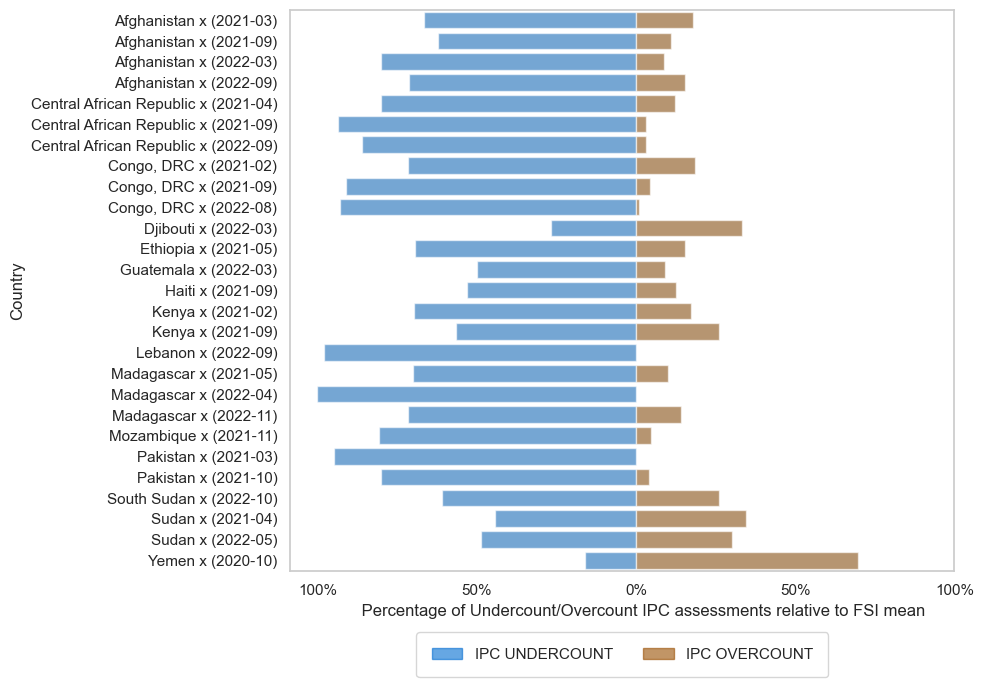

In [35]:
# =============================================================
# Group by Country x Round ('index') — for Plotting
# =============================================================
agg_level = 'index'

df_conserve_count_df = (
    df.groupby(agg_level)['obs-avg']
    .value_counts(normalize=True)
    .reset_index(name='normalized_counts')
)
df_conserve_count_df = df_conserve_count_df[df_conserve_count_df['obs-avg'] != 'no difference']
df_conserve_count_df['normalized_counts'] = np.where(
    df_conserve_count_df['obs-avg'] == 'negative',
    -df_conserve_count_df['normalized_counts'],
    df_conserve_count_df['normalized_counts']
)

wide_df = (
    df_conserve_count_df
    .pivot(index=agg_level, columns='obs-avg', values='normalized_counts')
    .reset_index()
    .rename(columns={'negative': 'undercount', 'positive': 'overcount'})
)

# Create readable label for each country-round
wide_df['country_round'] = wide_df['index'].apply(lambda x: f"{x[0]} x ({x[1]})")

# =============================================================
# Plotting
# =============================================================
fig, ax = plt.subplots(figsize=(10, 7))

# Undercount bars
ax1 = sns.barplot(
    x='undercount', y='country_round', data=wide_df,
    order=sorted(wide_df['country_round'].unique()),
    color='#006CD1', alpha=0.6
)

# Overcount bars
ax2 = sns.barplot(
    x='overcount', y='country_round', data=wide_df,
    order=sorted(wide_df['country_round'].unique()),
    color='#994F00', alpha=0.6
)

# Disable grid lines
ax1.grid(False)
ax2.grid(False)

# Custom legend
overcount_patch  = mpatches.Patch(color='#994F00', label='IPC OVERCOUNT', alpha=0.6)
undercount_patch = mpatches.Patch(color='#006CD1', label='IPC UNDERCOUNT', alpha=0.6)
plt.legend(
    handles=[undercount_patch, overcount_patch],
    bbox_to_anchor=(0.5, -0.15), loc='center', ncol=2,
    borderpad=1, fontsize=11, title_fontsize=10
)

# Axes and labels
plt.xlabel("         Percentage of Undercount/Overcount IPC assessments relative to FSI mean", loc='center', fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.xticks(
    ticks=[-1, -0.5, 0, 0.5, 1],
    labels=['100%', '50%', '0%', '50%', '100%']
)

plt.grid(False)
plt.tight_layout()
plt.show()

# Figure A7. Relationship between the HFA and the Difference in Consensus-Based and FSI implied 3+ Population Estimates (%)

In [36]:
# Load AFG HFA data
afg_hfa = pd.read_csv(home+r'\stores\data\afg_hfa.csv')
afg_hfa['gap3'] = afg_hfa['phase3_plus_up'] - afg_hfa['average3_up']
afg_hfa[['country','ipc_period','phase3_plus_up','average3_up','HFA_total_Current']].head()

,country,ipc_period,phase3_plus_up,average3_up,HFA_total_Current
0,Afghanistan,2022-09-01,0.50,0.55,0.21750
1,Afghanistan,2022-09-01,0.50,0.55,0.18000
2,Afghanistan,2022-09-01,0.35,0.40,0.07650
3,Afghanistan,2022-09-01,0.35,0.40,0.07700
4,Afghanistan,2022-09-01,0.40,0.50,0.19575


                            OLS Regression Results                            
Dep. Variable:                   gap3   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.224
Date:                Mon, 20 Oct 2025   Prob (F-statistic):             0.0743
Time:                        12:09:49   Log-Likelihood:                 153.23
No. Observations:                 180   AIC:                            -302.5
Df Residuals:                     178   BIC:                            -296.1
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0609      0.01

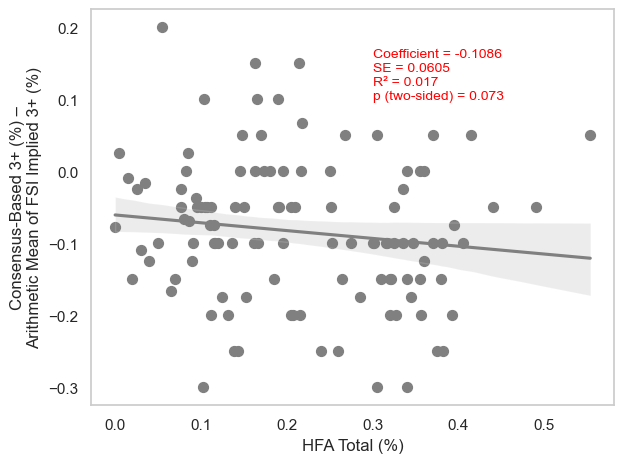

In [37]:
# =============================================================
# Linear Regression: gap3 ~ HFA_total_Current
# =============================================================
df_filtered = afg_hfa.copy()

# define x and y
X = sm.add_constant(df_filtered['HFA_total_Current'])
y = df_filtered['gap3']

# fit the OLS model (heteroskedasticity-robust SEs)
model = sm.OLS(y, X).fit(cov_type='HC1')

# model summary
print(model.summary())

# extract key statistics
coef = model.params["HFA_total_Current"]
se = model.bse["HFA_total_Current"]
pval = model.pvalues["HFA_total_Current"]
r2 = model.rsquared

# =============================================================
# Plot
# =============================================================
ax = sns.regplot(
    data=df_filtered,
    x='HFA_total_Current', y='gap3',
    x_estimator=np.mean, x_ci=None,
    color='gray', order=1
)

# labels
ax.set_ylabel('Consensus-Based 3+ (%) –\nArithmetic Mean of FSI Implied 3+ (%)')
ax.set_xlabel('HFA Total (%)')

# Annotate results
plt.text(
    x=0.30, y=0.10,
    s=(
        f'Coefficient = {coef:.4f}\n'
        f'SE = {se:.4f}\n'
        f'R² = {r2:.3f}\n'
        f'p (two-sided) = {pval:.3f}'
    ),
    color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)

plt.grid(False)
plt.tight_layout()
plt.show()


# Figure A8. Observed and estimated distributions of IPC assessments defined by the proportion of population in phase 4+: 4, 5, 6, 7th polynomial counterfactual

In [38]:
# =============================================================
# Initialize bunching analyzer for Phase 4+ Pop (%)
# =============================================================

poly = 6 # Replace alternatives like 5, 6, 7 for robustness
sim = BunchingAnalysis(
    data_series=rounded_df['phase4plus_perc'],
    poly_degree=poly,  
    seed=123
)

# =============================================================
# Scenario 1: Sequential Exclusion Simulation
# =============================================================
_, mean_coefficients1, std_error1 = sim.scenario1(
    num_simulations=500,
    exclude_points=[0.175, 0.225, 0.275, 0.325]
)

# =============================================================
# Scenario 2: Full-bin Bootstrap Simulation (No Exclusions)
# =============================================================
_, mean_coefficients2, std_error2 = sim.scenario2(
    num_simulations=500
)

# =============================================================
# Scenario 3: Exclude ±1 Binwidth Around z*
# =============================================================
_, mean_coefficients3, std_error3 = sim.scenario3(
    num_simulations=500,
    zstar=0.20
)

# Print polynomial degree used
print(f'Testing {poly}th Polynomial Fitting')


Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
Testing 6th Polynomial Fitting


In [39]:
# =============================================================
# Summary of Binned ORiginal Data
# =============================================================
rounded_with_bins= sim.add_bin_midpoint_column(rounded_df,'phase4plus_perc' )

summary = rounded_with_bins.groupby('bin_midpoint')['estimated_population'].agg(
    **{
        'average population (in millions)': 'mean',
        'original_observation': 'count'
    }
).reset_index()
summary

,bin_midpoint,average population (in millions),original_observation
0,0.00,358049.026148,3136
1,0.05,305475.050073,2736
2,0.10,254771.082360,1712
3,0.15,225783.692004,1013
4,0.20,252299.153499,443
5,0.25,226096.723684,152
6,0.30,241088.267606,71
7,0.35,98980.960000,50
8,0.40,124647.739130,23
9,0.45,150904.606061,33


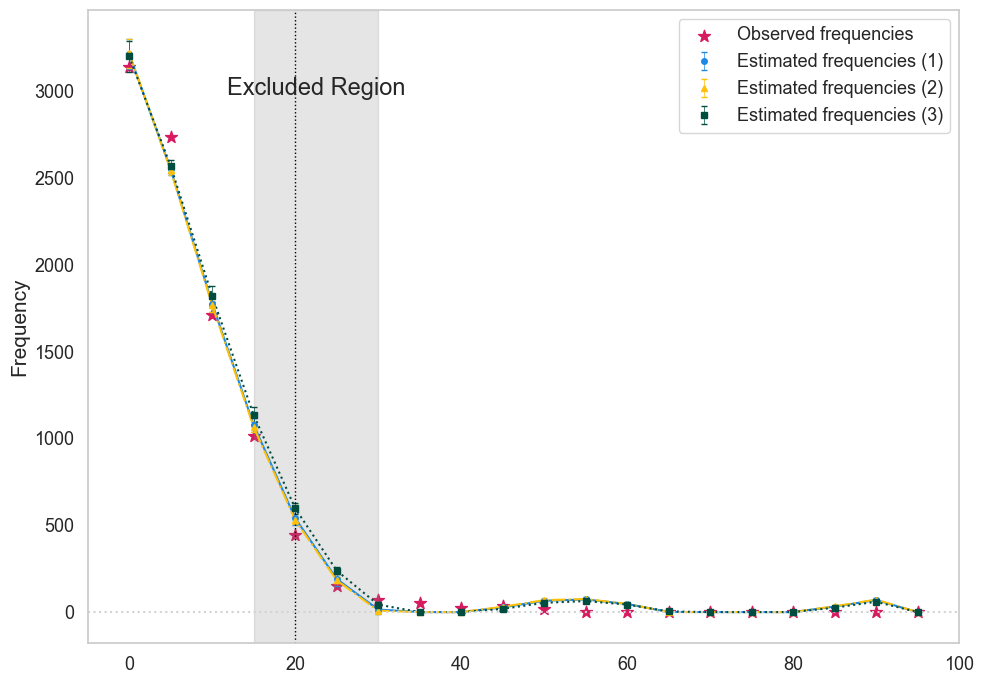

Testing 6th Polynomial Fitting


In [40]:
# --------------------------------------------------------------
# Calculate excess mass
# --------------------------------------------------------------
bin_midpoints = np.array(summary['bin_midpoint'])
binned_data_orig = np.array(summary['original_observation'])

agg_df = pd.DataFrame({
    'bins': bin_midpoints - 0.025,
    'binned_data_orig': binned_data_orig,
    'mean_coefficients': mean_coefficients1,
    'std_devs': std_error1
})
agg_df['excess_mass'] = agg_df['binned_data_orig'] - agg_df['mean_coefficients']
agg_df['excess_mass_perc'] = agg_df['excess_mass'] / agg_df['mean_coefficients']

# --------------------------------------------------------------
# Plot Set Up
# --------------------------------------------------------------
fig, axs = plt.subplots(1, figsize=(10, 7))

# Observed data
handle0 = axs.scatter(bin_midpoints, binned_data_orig, 
                      label="Observed frequencies", color='#D81B60', marker='*', s=80)

# Estimated frequencies with error bars
handle1 = axs.errorbar(bin_midpoints, mean_coefficients1, yerr=std_error1*2, fmt='o', markersize=4,
                       color='#1E88E5', ecolor='#1E88E5', elinewidth=0.5, capsize=2)
handle2 = axs.errorbar(bin_midpoints, mean_coefficients2, yerr=std_error2*2, fmt='^', markersize=4,
                       color='#FFC107', ecolor='#FFC107', elinewidth=0.5, capsize=2)
handle3 = axs.errorbar(bin_midpoints, mean_coefficients3, yerr=std_error3*2, fmt='s', markersize=4,
                       color='#004D40', ecolor='#004D40', elinewidth=0.5, capsize=2)

# Line plots for each estimate
axs.plot(bin_midpoints, mean_coefficients1, color='#1E88E5')
axs.plot(bin_midpoints, mean_coefficients2, color='#FFC107', linestyle='-.')
axs.plot(bin_midpoints, mean_coefficients3, color='#004D40', linestyle=':')

# Markers
axs.axvline(x=0.20, color='black', linestyle=':', linewidth=1)
axs.axhline(y=0, color='lightgray', linestyle=':')
axs.axvspan(0.15, 0.30, color='gray', alpha=0.2)
axs.annotate("Excluded Region", (0.225, max(binned_data_orig)*0.95), ha='center', fontsize=17)

# Custom legend
axs.legend(
    [handle0, handle1, handle2, handle3],
    ['Observed frequencies',
     'Estimated frequencies (1)',
     'Estimated frequencies (2)',
     'Estimated frequencies (3)'],
    loc="upper right", ncol=1, fontsize=13
)

# Axis formatting
axs.set_xticks(np.arange(0, 1.2, 0.2))
axs.set_xticklabels([f'{int(x*100)}' for x in np.arange(0, 1.2, 0.2)])
axs.set_xlim([-0.05, 1.0])
axs.set_ylabel('Frequency', fontsize=15)
axs.tick_params(axis='x', labelsize=13)
axs.tick_params(axis='y', labelsize=13)
axs.grid(False)

plt.tight_layout()
plt.show()

# Print polynomial degree used
print(f'Testing {poly}th Polynomial Fitting')

# Figure A9. Monte-Carlo simulation results: analyzing the impact of excluding any one FSI on the estimated distribution of IPC assessments defined by the proportion of population in phase 3+ by FSI group

696


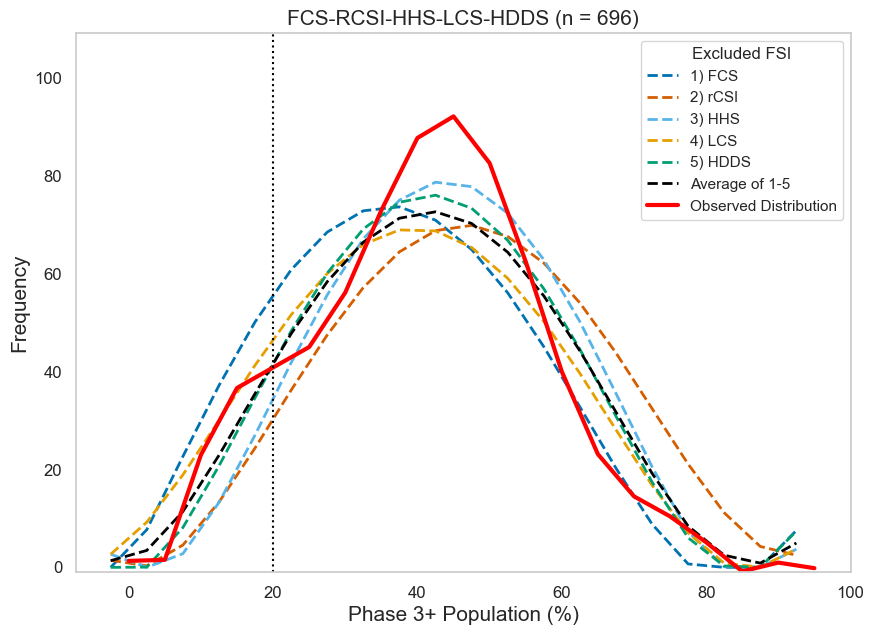

In [41]:

########################################################################
# Replace below parameter to specify the group
group = 'FCS-RCSI-HHS-LCS-HDDS'  # Options: 'FCS-RCSI-HHS-LCS', 'FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-LCS', 'FCS-RCSI-LCS-HDDS'
########################################################################

group_data = ipc_df_sub[(ipc_df_sub['FSI_combination'] == group)]

# Define indicator combinations used in simulation
combi_match = {
    'FCS-RCSI-HHS-LCS':      ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up'],
    'FCS-RCSI-HHS-LCS-HDDS': ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'],
    'FCS-RCSI-LCS':          ['FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up'],
    'FCS-RCSI-LCS-HDDS':     ['FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']
}

# =============================================================
# Define Binning for orriginal distribution
# =============================================================

zstar = 0.20
binwidth = 0.05
bins = np.arange(0, 1 + binwidth, binwidth)
binned_data_orig, _ = np.histogram(group_data['phase3_plus_up'].round(2), bins.round(2))
bin_midpoints_orig = (bins[:-1] + bins[1:]) / 2

print(len(group_data))

data_size = len(group_data)

# =============================================================
# Initialize coefficient matrices for Leave-One-Out Simulation
# =============================================================

coefficients_matrix_FCS  = np.zeros((num_simulations, 20))
coefficients_matrix_rCSI = np.zeros((num_simulations, 20))
coefficients_matrix_HHS  = np.zeros((num_simulations, 20))
coefficients_matrix_LCS  = np.zeros((num_simulations, 20))
coefficients_matrix_HDDS = np.zeros((num_simulations, 20))

exclude_var = combi_match[group_data['FSI_combination'].unique()[0]]

# =============================================================
# Run Leave-One-Out simulations for each indicator
# =============================================================

for n, v in enumerate(exclude_var):
    for j in range(num_simulations):
        new_lists = [exclude_var[:i] + exclude_var[i+1:] for i in range(len(exclude_var))]
        simulated_data = group_data.sample(data_size, replace=True)[new_lists[n]].mean(axis=1)
        binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))

        filtered_midpoints = bin_midpoints
        filtered_counts = binned_data

        coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
        poly_func = np.poly1d(coefficients)
        x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
        y_poly = poly_func(x_poly)
        y_poly = np.where(y_poly < 0, 0, y_poly)

        if n == 0:
            coefficients_matrix_FCS[j, :] = y_poly
        elif n == 1:
            coefficients_matrix_rCSI[j, :] = y_poly
        elif n == 2:
            coefficients_matrix_HHS[j, :] = y_poly
        elif n == 3:
            coefficients_matrix_LCS[j, :] = y_poly
        else:
            coefficients_matrix_HDDS[j, :] = y_poly

# =============================================================
# Combine all coefficients from different exclusion scenarios
# =============================================================

all_coefficients_matrix = np.vstack((
    coefficients_matrix_FCS,
    coefficients_matrix_rCSI,
    coefficients_matrix_HHS,
    coefficients_matrix_LCS,
    coefficients_matrix_HDDS
))

# =============================================================
# Plot simulated and observed distributions
# =============================================================

fig, ax = plt.subplots(figsize=(10, 7))
min_coef = []

for i, c in zip(
    [coefficients_matrix_FCS, coefficients_matrix_rCSI, coefficients_matrix_HHS, 
     coefficients_matrix_LCS, coefficients_matrix_HDDS,
     [coefficients_matrix_FCS, coefficients_matrix_rCSI, coefficients_matrix_HHS, coefficients_matrix_LCS, coefficients_matrix_HDDS]], 
    ['#0072B2', '#D55E00', '#56B4E9', '#E69F00', '#009E73', '#000000']
):
    all_coefficients_matrix = np.vstack((i))
    mean_coefficient1 = np.mean(all_coefficients_matrix, axis=0)
    std_error1 = np.std(all_coefficients_matrix, axis=0, ddof=1)
    
    ax.plot(bin_midpoints - 0.025, mean_coefficient1, color=c, alpha=1, linewidth=2, linestyle='dashed')
    min_coef.append(min(mean_coefficient1))

# Fit and plot the original observed distribution
coefficients_origin = np.polyfit(bin_midpoints_orig, binned_data_orig, 10)
poly_func_origin = np.poly1d(coefficients_origin)
x_poly_origin = np.linspace(min(bin_midpoints_orig), max(bin_midpoints_orig), 20)
y_poly_origin = poly_func_origin(x_poly_origin)
ax.plot(x_poly_origin - 0.025, y_poly_origin, color='red', alpha=1, linewidth=3)

# =============================================================
# Final plot formatting
# =============================================================

ax.legend(
    title='Excluded FSI', 
    labels=['1) FCS','2) rCSI','3) HHS','4) LCS', '5) HDDS','Average of 1-5', 'Observed Distribution']
)

ax.axvline(x=0.2, color='black', linestyle=':')
ax.set_ylim(-1, max(binned_data_orig) * 1.2)

ax.set_title(f'{group} (n = {len(group_data)})', fontsize=15)

locations = np.arange(0, 1.2, 0.2)
ax.set_xticks(locations)
ax.set_xticklabels(np.arange(0, 120, 20))

ax.set_xlabel('Phase 3+ Population (%)', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.grid(False)


# Table A5. Determinants of FSI availability: A logistic regression across 32 countries

Because we only observe FSI data for a subset of our assessments, we investigate the generalizability of our results from the FSI analyses by evaluating whether we observe systematic differences between the samples with and without FSI data (sample C versus sample A from Table A1 in the main text). We employ a logistic regression to explore if and how various country-level characteristics —including GDP, measured in purchasing power parity (IMF 2024), ln(conflict-related fatalities)  (Raleigh et al. 2010), democratic measures (EIU 2022), ln(average population) (World Bank 2024), and the average phase classification at the country level— predict the likelihood of a country having underlying FSI information (1 if a country has FSI information, 0 otherwise). We find that locations are generally similar across these dimensions, with the notable distinction being higher conflict-related fatalities observed in areas with FSI data.

In [42]:
# IPC country list with country name to ISO 3-letter code mapping
country_codes = {
    'Afghanistan': 'AFG',
    'Bangladesh': 'BGD',
    'Pakistan': 'PAK',
    'Timor-Leste': 'TLS',
    'Burundi': 'BDI',
    'Central African Republic': 'CAF',
    'Congo, DRC': 'COD',  # Democratic Republic of the Congo
    'Djibouti': 'DJI',
    'Ethiopia': 'ETH',
    'Kenya': 'KEN',
    'Somalia': 'SOM',
    'South Sudan': 'SSD',
    'Sudan': 'SDN',
    'Tanzania': 'TZA',
    'Uganda': 'UGA',
    'Angola': 'AGO',
    'Eswatini': 'SWZ',
    'Lesotho': 'LSO',
    'Madagascar': 'MDG',
    'Malawi': 'MWI',
    'Mozambique': 'MOZ',
    'Namibia': 'NAM',
    'South Africa': 'ZAF',
    'Zambia': 'ZMB',
    'Zimbabwe': 'ZWE',
    'Dominican Republic': 'DOM',
    'El Salvador': 'SLV',
    'Guatemala': 'GTM',
    'Haiti': 'HTI',
    'Honduras': 'HND',
    'LAC Region (tri-National)': 'LAC',  # Not a country, custom code
    'Lebanon': 'LBN',
    'Yemen': 'YEM'
}

# Sorted list of all ISO codes
iso_codes_3_org = sorted([code for code in country_codes.values() if code is not None])

# Output full list
print(iso_codes_3_org)


['AFG', 'AGO', 'BDI', 'BGD', 'CAF', 'COD', 'DJI', 'DOM', 'ETH', 'GTM', 'HND', 'HTI', 'KEN', 'LAC', 'LBN', 'LSO', 'MDG', 'MOZ', 'MWI', 'NAM', 'PAK', 'SDN', 'SLV', 'SOM', 'SSD', 'SWZ', 'TLS', 'TZA', 'UGA', 'YEM', 'ZAF', 'ZMB', 'ZWE']


## Democratic Index
data source: https://ourworldindata.org/grapher/democracy-index-eiu?tab=table

In [43]:
# Load the Democracy Index dataset from a CSV file
democ_df = pd.read_csv(home + r'\stores\data\democracy-index-eiu.csv')

# Filter to include only countries in the ISO code list and rename columns for consistency
democ_ipc_df = democ_df[democ_df['Code'].isin(iso_codes_3_org)].rename(columns={
    'Code': 'countrycode',
    'Year': 'year',
    'Entity': 'country'
})

# Assign Democracy Index value of 0 to Somalia (SOM) and South Sudan (SSD) (Index doesn't exist)
democ_ipc_df['democracy_eiu'] = np.where(
    democ_ipc_df['countrycode'].isin(['SOM', 'SSD']),
    0,
    democ_ipc_df['democracy_eiu']
)

# DI Available countries
print('Demo Index Available Countries: ', democ_ipc_df['countrycode'].unique(), democ_ipc_df['countrycode'].nunique())

# Preview the cleaned dataframe
democ_ipc_df


Demo Index Available Countries:  ['AFG' 'AGO' 'BGD' 'BDI' 'CAF' 'COD' 'DJI' 'DOM' 'TLS' 'SLV' 'SWZ' 'ETH'
 'GTM' 'HTI' 'HND' 'KEN' 'LBN' 'LSO' 'MDG' 'MWI' 'MOZ' 'NAM' 'PAK' 'ZAF'
 'SDN' 'TZA' 'UGA' 'YEM' 'ZMB' 'ZWE'] 30


,country,countrycode,year,democracy_eiu
0,Afghanistan,AFG,2006,3.06
1,Afghanistan,AFG,2008,3.02
2,Afghanistan,AFG,2010,2.48
3,Afghanistan,AFG,2011,2.48
4,Afghanistan,AFG,2012,2.48
...,...,...,...,...
2605,Zimbabwe,ZWE,2018,3.16
2606,Zimbabwe,ZWE,2019,3.16
2607,Zimbabwe,ZWE,2020,3.16
2608,Zimbabwe,ZWE,2021,2.92


# IMF GDP per capita & OurWorldinData - populaion

https://ourworldindata.org/grapher/gdp-per-capita-worldbank?tab=table&time=2015..latest

https://ourworldindata.org/grapher/population?tab=table&time=2017..latest

https://www.imf.org/external/datamapper/NGDPDPC@WEO/OEMDC/ADVEC/WEOWORLD/YEM

In [44]:
# Load the IMF GDP dataset
imf_gdp_df = pd.read_csv(home + r'\stores\data\imf-gdp-ppp.csv').rename(columns={'Unnamed: 0': 'country_name'})

# Convert wide-format data into long-format
imf_gdp_df_long = pd.melt(
    imf_gdp_df,
    id_vars=['country_name'],
    value_vars=['2017', '2018', '2019', '2020', '2021', '2022', '2023'],
    var_name='year',
    value_name='gdp_ppp'
)

# Country name to ISO3 code mapping
imf_names_to_codes = {
    'Afghanistan': 'AFG',
    'Angola': 'AGO',
    'Burundi': 'BDI',
    'Bangladesh': 'BGD',
    'Central African Republic': 'CAF',
    'Congo, Dem. Rep. of the': 'COD',
    'Djibouti': 'DJI',
    'Dominican Republic': 'DOM',
    'Ethiopia': 'ETH',
    'Guatemala': 'GTM',
    'Honduras': 'HND',
    'Haiti': 'HTI',
    'Kenya': 'KEN',
    'Lebanon': 'LBN',
    'Lesotho': 'LSO',
    'Madagascar': 'MDG',
    'Mozambique': 'MOZ',
    'Malawi': 'MWI',
    'Namibia': 'NAM',
    'Pakistan': 'PAK',
    'Sudan': 'SDN',
    'El Salvador': 'SLV',
    'Somalia': 'SOM',
    'South Sudan, Republic of': 'SSD',
    'Eswatini': 'SWZ',
    'Timor-Leste': 'TLS',
    'Tanzania': 'TZA',
    'Uganda': 'UGA',
    'Yemen': 'YEM',
    'South Africa': 'ZAF',
    'Zambia': 'ZMB',
    'Zimbabwe': 'ZWE'
}

# Replace country names with ISO3 codes
imf_gdp_df_long['countrycode'] = imf_gdp_df_long['country_name'].replace(imf_names_to_codes)

# Keep only relevant ISO-coded countries
imf_gdp_df_final = imf_gdp_df_long[imf_gdp_df_long['countrycode'].isin(imf_names_to_codes.values())]

# Filter out 'no data' values
imf_gdp_df_final = imf_gdp_df_final[imf_gdp_df_final['gdp_ppp'] != 'no data']

# Convert GDP values to float
imf_gdp_df_final['gdp_ppp'] = imf_gdp_df_final['gdp_ppp'].astype('float64')
imf_gdp_df_final

,country_name,year,gdp_ppp,countrycode
0,Afghanistan,2017,635.789,AFG
4,Angola,2017,4039.300,AGO
14,Bangladesh,2017,1839.755,BGD
28,Burundi,2017,291.859,BDI
33,Central African Republic,2017,450.744,CAF
...,...,...,...,...
1350,Timor-Leste,2023,1497.408,TLS
1358,Uganda,2023,1163.034,UGA
1369,Yemen,2023,617.670,YEM
1370,Zambia,2023,1435.890,ZMB


In [45]:
# Load the population dataset
pop_df = pd.read_csv(home + r'\stores\data\population.csv').rename(columns={
    'Population (historical estimates)': 'population',
    'Code': 'countrycode',
    'Year': 'year',
    'Entity': 'country_name'
})

# Filter data for years >= 2017 and country codes in the IPC list
pop_df = pop_df[
    (pop_df['year'] >= 2017) & 
    (pop_df['countrycode'].isin(iso_codes_3_org))
]
pop_df

,country_name,countrycode,year,population
254,Afghanistan,AFG,2017,35643420
255,Afghanistan,AFG,2018,36686788
256,Afghanistan,AFG,2019,37769496
257,Afghanistan,AFG,2020,38972236
258,Afghanistan,AFG,2021,40099460
...,...,...,...,...
58247,Zimbabwe,ZWE,2017,14751101
58248,Zimbabwe,ZWE,2018,15052191
58249,Zimbabwe,ZWE,2019,15354606
58250,Zimbabwe,ZWE,2020,15669663



## Loading ACLED

API: https://apidocs.acleddata.com/generalities_section.html

ACLED country list: https://acleddata.com/acleddatanew/wp-content/uploads/dlm_uploads/2019/01/ACLED_Country-and-Time-Period-coverage_updatedFeb2022.pdf

ACLED Access Guid: https://acleddata.com/acleddatanew/wp-content/uploads/2021/11/ACLED_Access-Guide_October-2020.pdf

In [46]:
# Load the ACLED
acled_result_df = pd.read_csv(home + r'\stores\data\country_level_fatalities_acled.csv')

# Define mapping of country names to their 3-digit ISO country codes
country_codes_3_digit = {
    'Afghanistan': 'AFG',
    'Angola': 'AGO',
    'Bangladesh': 'BGD',
    'Burundi': 'BDI',
    'Central_African_Republic': 'CAF',
    'Congo_DRC': 'COD',
    'Djibouti': 'DJI',
    'Dominican_Republic': 'DOM',
    'El_Salvador': 'SLV',
    'Eswatini': 'SWZ',
    'Ethiopia': 'ETH',
    'Guatemala': 'GTM',
    'Haiti': 'HTI',
    'Honduras': 'HND',
    'Kenya': 'KEN',
    'Lebanon': 'LBN',
    'Lesotho': 'LSO',
    'Madagascar': 'MDG',
    'Malawi': 'MWI',
    'Mozambique': 'MOZ',
    'Namibia': 'NAM',
    'Pakistan': 'PAK',
    'Somalia': 'SOM',
    'South_Africa': 'ZAF',
    'South_Sudan': 'SSD',
    'Sudan': 'SDN',
    'Tanzania': 'TZA',
    'Timor_Leste': 'TLS',
    'Uganda': 'UGA',
    'Yemen': 'YEM',
    'Zambia': 'ZMB',
    'Zimbabwe': 'ZWE'
}

# Replace 'country_name' with ISO codes
acled_result_df['countrycode'] = acled_result_df['country_name'].replace(country_codes_3_digit)

# Create unique index of country X yearmon
acled_result_df['index2'] = acled_result_df.set_index(['countrycode', 'yearmon']).index
acled_result_df

,Unnamed: 0,yearmon,fatalities,country_name,countrycode,index2
0,0,2017-01,28980,Afghanistan,AFG,"(AFG, 2017-01)"
1,1,2017-02,26556,Afghanistan,AFG,"(AFG, 2017-02)"
2,2,2017-03,38604,Afghanistan,AFG,"(AFG, 2017-03)"
3,3,2017-04,44172,Afghanistan,AFG,"(AFG, 2017-04)"
4,4,2017-05,52212,Afghanistan,AFG,"(AFG, 2017-05)"
...,...,...,...,...,...,...
2459,79,2023-08,12,Zimbabwe,ZWE,"(ZWE, 2023-08)"
2460,80,2023-09,24,Zimbabwe,ZWE,"(ZWE, 2023-09)"
2461,81,2023-10,36,Zimbabwe,ZWE,"(ZWE, 2023-10)"
2462,82,2023-11,12,Zimbabwe,ZWE,"(ZWE, 2023-11)"


## Load IPC Study Sample A (n = 9394)

In [47]:
# IPC Study Sample A
country_codes = {
    'Afghanistan': 'AFG',
    'Bangladesh': 'BGD',
    'Pakistan': 'PAK',
    'Timor-Leste': 'TLS',
    'Burundi': 'BDI',
    'Central African Republic': 'CAF',
    'Congo, DRC': 'COD',  # Democratic Republic of the Congo
    'Djibouti': 'DJI',
    'Ethiopia': 'ETH',
    'Kenya': 'KEN',
    'Somalia': 'SOM',
    'South Sudan': 'SSD',
    'Sudan': 'SDN',
    'Tanzania': 'TZA',
    'Uganda': 'UGA',
    'Angola': 'AGO',
    'Eswatini': 'SWZ',
    'Lesotho': 'LSO',
    'Madagascar': 'MDG',
    'Malawi': 'MWI',
    'Mozambique': 'MOZ',
    'Namibia': 'NAM',
    'South Africa': 'ZAF',
    'Zambia': 'ZMB',
    'Zimbabwe': 'ZWE',
    'Dominican Republic': 'DOM',
    'El Salvador': 'SLV',
    'Guatemala': 'GTM',
    'Haiti': 'HTI',
    'Honduras': 'HND',
    'LAC Region (tri-National)': 'LAC',  # This is not a country, hence no ISO code
    'Lebanon': 'LBN',
    'Yemen': 'YEM'
}

rounded_df['countrycode'] = rounded_df['country_name'].replace(country_codes)
rounded_df['index2'] = rounded_df.set_index(['countrycode','yearmon']).index


ipc_study_df_uniq_country = rounded_df['countrycode'].unique()
ipc_study_df_uniq_index = rounded_df['index2'].unique()

print('Unique country from IPC Sample C:', ipc_study_df_uniq_country)

Unique country from IPC Sample C: ['AFG' 'BGD' 'PAK' 'TLS' 'BDI' 'CAF' 'COD' 'DJI' 'ETH' 'KEN' 'SOM' 'SSD'
 'SDN' 'TZA' 'UGA' 'AGO' 'SWZ' 'LSO' 'MDG' 'MWI' 'MOZ' 'NAM' 'ZAF' 'ZMB'
 'ZWE' 'DOM' 'SLV' 'GTM' 'HTI' 'HND' 'LAC' 'LBN' 'YEM']


## Load IPC Study Sample C (n = 1849)

In [48]:
# Load S
two_to_three_digit_codes = {
    'MG': 'MDG',  # Madagascar
    'ET': 'ETH',  # Ethiopia
    'DJ': 'DJI',  # Djibouti
    'LB': 'LBN',  # Lebanon
    'KE': 'KEN',  # Kenya
    'HT': 'HTI',  # Haiti
    'GT': 'GTM',  # Guatemala
    'YE': 'YEM',  # Yemen
    'PK': 'PAK',  # Pakistan
    'MZ': 'MOZ',  # Mozambique
    'SS': 'SSD',  # South Sudan
    'CD': 'COD',  # Congo, Democratic Republic of the
    'CF': 'CAF',  # Central African Republic
    'AF': 'AFG',  # Afghanistan
    'SD': 'SDN',  # Sudan
}


# Create necessary columns for merging
ipc_df_sub['countrycode'] = ipc_df_sub['country_code'].replace(two_to_three_digit_codes)
ipc_df_sub['year'] = ipc_df_sub['yearmon'].str[:4].astype('str')

ipc_df_sub['index2'] = ipc_df_sub.set_index(['countrycode','yearmon']).index


# Dictionary specifying replacements (FSI name -> IPC bigger sample name)
fsi_to_biggersample_replacements = {
    ('COD', '2022-08'): ('COD', '2022-07'),
    ('KEN', '2021-09'): ('KEN', '2021-07'),
    ('MDG', '2021-05'): ('MDG', '2021-04'),
    ('SDN', '2022-05'): ('SDN', '2022-04'),
    ('CAF', '2021-04'): ('CAF', '2020-09'), # 2021-04 projection updated for CAF 2020-09
    # Add more replacements as needed
}

# Apply replacements
ipc_df_sub['index2'] = ipc_df_sub['index2'].apply(lambda x: fsi_to_biggersample_replacements[x] if x in fsi_to_biggersample_replacements else x)

# Create list of countrycode and index2
ipc_study_fsi_df_uniq_country = ipc_df_sub['countrycode'].unique()
ipc_study_fsi_df_uniq_index = ipc_df_sub['index2'].unique()

print('Unique country from IPC Sample C:', ipc_study_fsi_df_uniq_country)


Unique country from IPC Sample C: ['MDG' 'ETH' 'DJI' 'LBN' 'KEN' 'HTI' 'GTM' 'YEM' 'PAK' 'MOZ' 'SSD' 'COD'
 'CAF' 'AFG' 'SDN']


In [49]:
# Indicate FSI available Country vs FSI available Country X Round
rounded_df['fsi_exist_country'] = np.where(rounded_df['countrycode'].isin(ipc_study_fsi_df_uniq_country),1, 0)
rounded_df['fsi_exist_index'] = np.where(rounded_df['index2'].isin(ipc_study_fsi_df_uniq_index),1, 0)

# Group By TWG or Country
twg_level_df = rounded_df[['fsi_exist_country','fsi_exist_index','year','countrycode','index2','yearmon','overall_phase']].drop_duplicates(subset = ['countrycode','index2'])
country_level_df = rounded_df[['fsi_exist_country','fsi_exist_index','year','countrycode','index2','yearmon','overall_phase']].drop_duplicates(subset = 'countrycode')

# For generating Table A4 in the SI
country_level_df

,fsi_exist_country,fsi_exist_index,year,countrycode,index2,yearmon,overall_phase
0,1,0,2023,AFG,"(AFG, 2023-10)",2023-10,3.0
504,0,0,2023,BGD,"(BGD, 2023-03)",2023-03,3.0
521,1,0,2023,PAK,"(PAK, 2023-04)",2023-04,3.0
674,0,0,2022,TLS,"(TLS, 2022-11)",2022-11,3.0
688,0,0,2023,BDI,"(BDI, 2023-09)",2023-09,2.0
784,1,0,2023,CAF,"(CAF, 2023-09)",2023-09,3.0
1377,1,0,2023,COD,"(COD, 2023-07)",2023-07,3.0
2620,1,0,2023,DJI,"(DJI, 2023-03)",2023-03,3.0
2665,1,1,2021,ETH,"(ETH, 2021-05)",2021-05,3.0
2928,1,0,2023,KEN,"(KEN, 2023-07)",2023-07,2.0


In [50]:
# List of years
years = range(2017, 2023)

# Data for new rows - This is necessary because EIU provides no Democracy Index for South Sudan and Somalia
new_rows = []
for year in years:
    new_rows.append({"country": "South Sudan", "countrycode": "SSD", "year": year, "democracy_eiu": 0})
    new_rows.append({"country": "Somalia", "countrycode": "SOM", "year": year, "democracy_eiu": 0})

# Append new data to the df
democ_ipc_df = pd.concat([democ_ipc_df, pd.DataFrame(new_rows)], ignore_index=True)

democ_ipc_df

,country,countrycode,year,democracy_eiu
0,Afghanistan,AFG,2006,3.06
1,Afghanistan,AFG,2008,3.02
2,Afghanistan,AFG,2010,2.48
3,Afghanistan,AFG,2011,2.48
4,Afghanistan,AFG,2012,2.48
...,...,...,...,...
457,Somalia,SOM,2020,0.00
458,South Sudan,SSD,2021,0.00
459,Somalia,SOM,2021,0.00
460,South Sudan,SSD,2022,0.00


In [51]:
# =============================================================
# Merge country-level dataset with log-transformed covariates
# =============================================================
acled_fatal = acled_result_df.groupby('countrycode')['fatalities'].mean().reset_index()
acled_fatal['log_fatalities'] = np.log(acled_fatal['fatalities'])

pop_mean = pop_df.groupby('countrycode')['population'].mean().reset_index()
pop_mean['log_population'] = np.log(pop_mean['population'])

gdp_mean = imf_gdp_df_final.groupby('countrycode')['gdp_ppp'].mean().reset_index()
gdp_mean['log_gdp_ppp'] = np.log(gdp_mean['gdp_ppp'])

democ_mean = democ_ipc_df.groupby('countrycode')['democracy_eiu'].mean().reset_index()

country_merg_df = (
    country_level_df[['fsi_exist_country', 'countrycode', 'overall_phase']]
    .merge(acled_fatal[['countrycode','log_fatalities']], on='countrycode', how='left')
    .merge(pop_mean[['countrycode','log_population']], on='countrycode', how='left')
    .merge(gdp_mean[['countrycode','log_gdp_ppp']], on='countrycode', how='left')
    .merge(democ_mean, on='countrycode', how='left')
)

logit_df = country_merg_df.dropna()

# =============================================================
# Define predictors and target
# =============================================================
X = logit_df[['log_fatalities', 'democracy_eiu', 'log_gdp_ppp', 'log_population', 'overall_phase']]
y = logit_df['fsi_exist_country']

# =============================================================
# Add constant and fit logistic regression (robust SE)
# =============================================================
X_const = sm.add_constant(X)
model = sm.Logit(y, X_const).fit(cov_type = 'HC1')

# =============================================================
# Summarize
# =============================================================
summary = model.summary2().tables[1]
print(summary)


Optimization terminated successfully.
         Current function value: 0.445463
         Iterations 6
                   Coef.  Std.Err.         z     P>|z|     [0.025     0.975]
const          -3.485725  7.308227 -0.476959  0.633391 -17.809588  10.838137
log_fatalities  0.773390  0.344843  2.242735  0.024914   0.097511   1.449269
democracy_eiu  -0.166625  0.480989 -0.346421  0.729026  -1.109345   0.776096
log_gdp_ppp     0.047643  0.598059  0.079663  0.936505  -1.124531   1.219818
log_population -0.251755  0.415849 -0.605400  0.544913  -1.066805   0.563294
overall_phase   1.230541  1.445267  0.851428  0.394531  -1.602129   4.063212


In [52]:
# =============================================================
# Step 1: Merge Country-Level Features
# =============================================================
country_merg_df = country_level_df[['fsi_exist_country', 'countrycode', 'overall_phase']] \
    .merge(np.log(acled_result_df.groupby('countrycode')['fatalities'].mean()).reset_index(),
           on='countrycode', how='left') \
    .merge(np.log(pop_df.groupby('countrycode')['population'].mean()).reset_index(),
           on='countrycode', how='left') \
    .merge(np.log(imf_gdp_df_final.groupby('countrycode')['gdp_ppp'].mean()).reset_index(),
           on='countrycode', how='left') \
    .merge(democ_ipc_df.groupby('countrycode')['democracy_eiu'].mean().reset_index(),
           on='countrycode', how='left')

# =============================================================
# Drop missing values
# =============================================================
logit_df = country_merg_df.dropna()

# =============================================================
# Step 3: Define Features (X) and Target (y)
# =============================================================
X = logit_df[['fatalities', 'democracy_eiu', 'gdp_ppp', 'population', 'overall_phase']]
y = logit_df['fsi_exist_country']

# =============================================================
# Step 4: Add Constant and Fit Logistic Regression
# =============================================================
X_const = sm.add_constant(X)
model = sm.Logit(y, X_const).fit()

# =============================================================
# Step 5: Summarize Results
# =============================================================
summary = model.summary2().tables[1]  # Coefficient table only
summary


Optimization terminated successfully.
         Current function value: 0.445463
         Iterations 6


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.485725,8.697817,-0.400759,0.688598,-20.533134,13.561683
fatalities,0.773390,0.345715,2.237075,0.025281,0.095801,1.450979
democracy_eiu,-0.166625,0.360588,-0.462091,0.644016,-0.873364,0.540115
gdp_ppp,0.047643,0.644616,0.073910,0.941082,-1.215780,1.311067
population,-0.251755,0.453772,-0.554806,0.579027,-1.141132,0.637621
overall_phase,1.230541,1.112156,1.106446,0.268533,-0.949245,3.410328


# Figure A10. Observed and estimated distributions of IPC assessments defined by proportion of population in phase 3+: 3, 5, 6, 7th polynomial counterfactual distributions

In [53]:
# =============================================================
# Initialize Bunching Analyzer for Phase 3+ Pop (%)
# =============================================================
poly = 6
sim = BunchingAnalysis(
    data_series=rounded_df['phase3plus_perc'],
    poly_degree=poly,  # Try alternatives like 4, 5, 6 for robustness
    seed=123
)

# =============================================================
# Scenario 1: Sequential Exclusion Simulation
# =============================================================
_, mean_coefficients1, std_error1 = sim.scenario1(
    num_simulations=500,
    exclude_points=[0.175, 0.225, 0.275, 0.325]
)

# =============================================================
# Scenario 2: Full-bin Bootstrap Simulation (No Exclusions)
# =============================================================
_, mean_coefficients2, std_error2 = sim.scenario2(
    num_simulations=500
)

# =============================================================
# Scenario 3: Exclude ±1 Binwidth Around z*
# =============================================================
_, mean_coefficients3, std_error3 = sim.scenario3(
    num_simulations=500,
    zstar=0.20
)

print(f'Testing {poly}th Polynomial Fitting')


Excluding midpoint: 0.150
Excluding midpoint: 0.200
Excluding midpoint: 0.250
Excluding midpoint: 0.300
Testing 6th Polynomial Fitting


In [54]:
# Summary of Binned ORiginal Data

rounded_with_bins= sim.add_bin_midpoint_column(rounded_df,'phase3plus_perc' )

summary = rounded_with_bins.groupby('bin_midpoint')['estimated_population'].agg(
    **{
        'average population (in millions)': 'mean',
        'original_observation': 'count'
    }
).reset_index()
summary

,bin_midpoint,average population (in millions),original_observation
0,0.00,420849.546154,260
1,0.05,326115.705128,624
2,0.10,363403.828571,735
3,0.15,375568.920884,1403
4,0.20,294482.527721,974
5,0.25,311990.739496,833
6,0.30,332749.064603,743
7,0.35,256502.142322,801
8,0.40,272526.204330,739
9,0.45,304929.314685,572


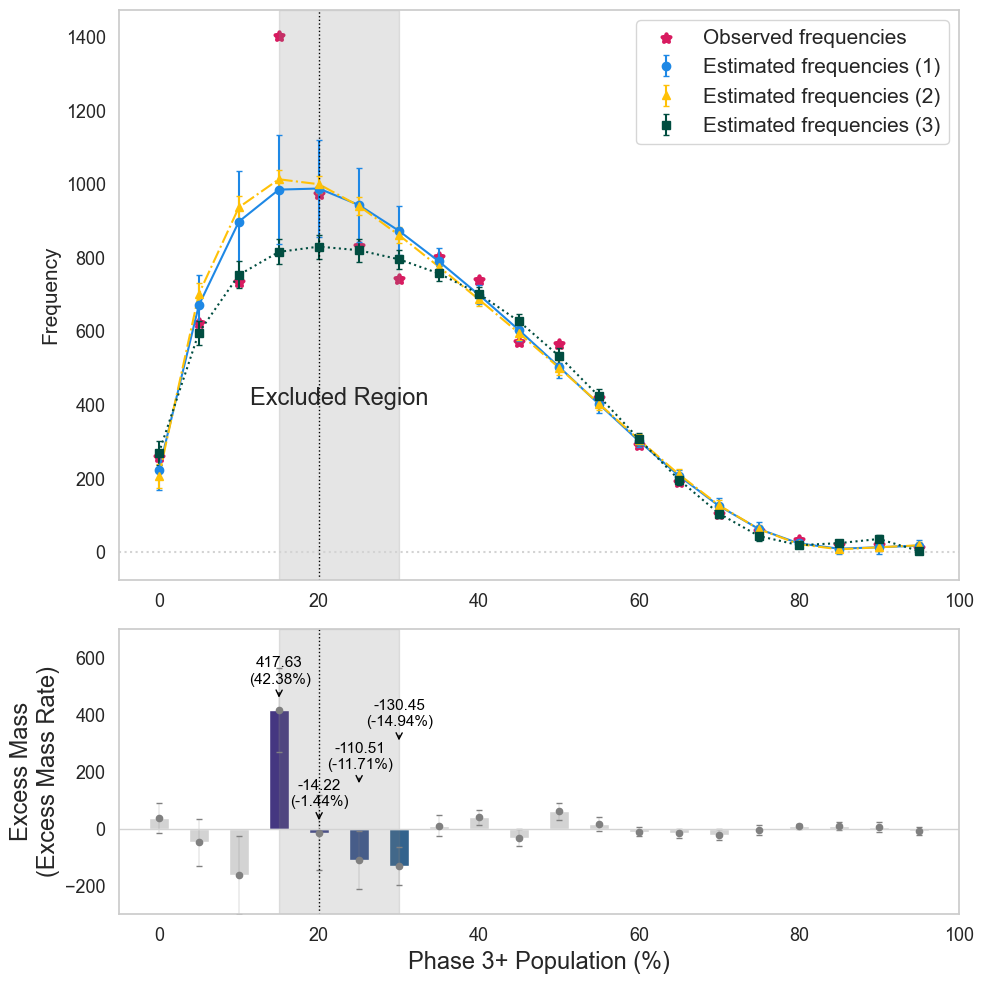

In [55]:
# =============================================================
# Load Midpoints and Original Data
# =============================================================
bin_midpoints = np.array(summary['bin_midpoint'])
binned_data_orig = np.array(summary['original_observation'])

# =============================================================
# Aggregate Simulation 1 Results into DF
# =============================================================
agg_df = pd.DataFrame({
    'bins': bin_midpoints,
    'binned_data_orig': binned_data_orig,
    'mean_coefficients': mean_coefficients1,
    'std_errors': std_error1
})
agg_df['excess_mass'] = agg_df['binned_data_orig'] - agg_df['mean_coefficients']
agg_df['excess_mass_perc'] = agg_df['excess_mass'] / agg_df['mean_coefficients']

# =============================================================
# Set Up Plot
# =============================================================
fig, axs = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})

# =============================================================
# Plot 1 – Observed vs Estimated Frequencies (Simulation 1, 2, 3)
# =============================================================
axs[0].scatter(bin_midpoints, binned_data_orig, label="Binned Data", color='#D81B60', marker='*', linewidth=3)

handle1 = axs[0].errorbar(bin_midpoints, mean_coefficients1, yerr=std_error1 * 2, fmt='o', color='#1E88E5', capsize=2)
handle2 = axs[0].errorbar(bin_midpoints, mean_coefficients2, yerr=std_error2 * 2, fmt='^', color='#FFC107', capsize=2)
handle3 = axs[0].errorbar(bin_midpoints, mean_coefficients3, yerr=std_error3 * 2, fmt='s', color='#004D40', capsize=2)

axs[0].plot(bin_midpoints, mean_coefficients1, color='#1E88E5')
axs[0].plot(bin_midpoints, mean_coefficients2, color='#FFC107', linestyle='-.')
axs[0].plot(bin_midpoints, mean_coefficients3, color='#004D40', linestyle=':')

axs[0].axvline(0.20, color='black', linestyle=':', linewidth=1)
axs[0].axhline(0.0, color='lightgray', linestyle=':')

axs[0].legend(
    [axs[0].collections[0], handle1, handle2, handle3],
    ['Observed frequencies', 'Estimated frequencies (1)', 'Estimated frequencies (2)', 'Estimated frequencies (3)'],
    loc='upper right', fontsize=15
)

axs[0].axvspan(0.15, 0.30, color='gray', alpha=0.2)
axs[0].set_xlim([-0.05, 1.0])
axs[0].set_xticks(np.arange(0, 1.2, 0.2))
axs[0].set_xticklabels(np.arange(0, 120, 20))
axs[0].annotate("Excluded Region", (0.225, 400), ha='center', fontsize=17)
axs[0].set_ylabel('Frequency', fontsize=15)

# =============================================================
# Plot 2 – Excess Mass from Simulation 1
# =============================================================
agg_df['bins'] = pd.Categorical(agg_df['bins'], categories=np.sort(agg_df['bins'].unique()), ordered=True)
x_range = [0.15, 0.20, 0.25, 0.30]

colors = ['viridis_r' if x in x_range else 'gray' for x in agg_df['bins']]
cmap_vals = np.linspace(0, 1, len(colors))
actual_colors = [
    to_hex(viridis(cmap_vals[i])) if c == 'viridis_r' else 'lightgray'
    for i, c in enumerate(colors)
]

axs[1].bar(agg_df['bins'], agg_df['excess_mass'], width=0.025, color=actual_colors)
axs[1].errorbar(agg_df['bins'], agg_df['excess_mass'], yerr=agg_df['std_errors'] * 2,
                fmt='o', color='gray', elinewidth=0.2, capsize=2, markersize=4.5)

agg_df['y_loc'] = [0, 0, 0, 450, 20, 150, 300] + [0] * (len(agg_df) - 7)
agg_df['x_loc'] = [0, 0, 0, 0.15, 0.20, 0.225, 0.335] + [0] * (len(agg_df) - 7)

for p, bin_val, perc, x, y in zip(axs[1].patches, agg_df['bins'], agg_df['excess_mass_perc'],
                                  agg_df['x_loc'], agg_df['y_loc']):
    if bin_val in x_range:
        axs[1].annotate(
            f"{p.get_height():.2f}\n({perc*100:.2f}%)",
            xy=(p.get_x() + p.get_width() / 2, y),
            xytext=(0.5, 10),
            textcoords="offset points",
            ha='center', va='bottom', fontsize=11, color='black',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black')
        )

axs[1].axvline(0.20, color='black', linestyle=':', linewidth=1)
axs[1].axhline(0, color='lightgray', linewidth=1)
axs[1].axvspan(0.15, 0.30, color='gray', alpha=0.2)

axs[1].set_xticks(np.arange(0, 1.2, 0.2))
axs[1].set_xticklabels(np.arange(0, 120, 20))
axs[1].set_xlim([-0.05, 1.0])
axs[1].set_ylim([-300, 700])
axs[1].set_xlabel('Phase 3+ Population (%)', fontsize=17)
axs[1].set_ylabel('Excess Mass\n(Excess Mass Rate)', fontsize=17)

axs[0].tick_params(labelsize=13)
axs[1].tick_params(labelsize=13)
axs[0].grid(False)
axs[1].grid(False)
plt.tight_layout()
plt.show()


# Figure A11. Differences between observed and estimated frequencies of IPC assessments defined by the proportion of population in phase 3+ by 5% bin

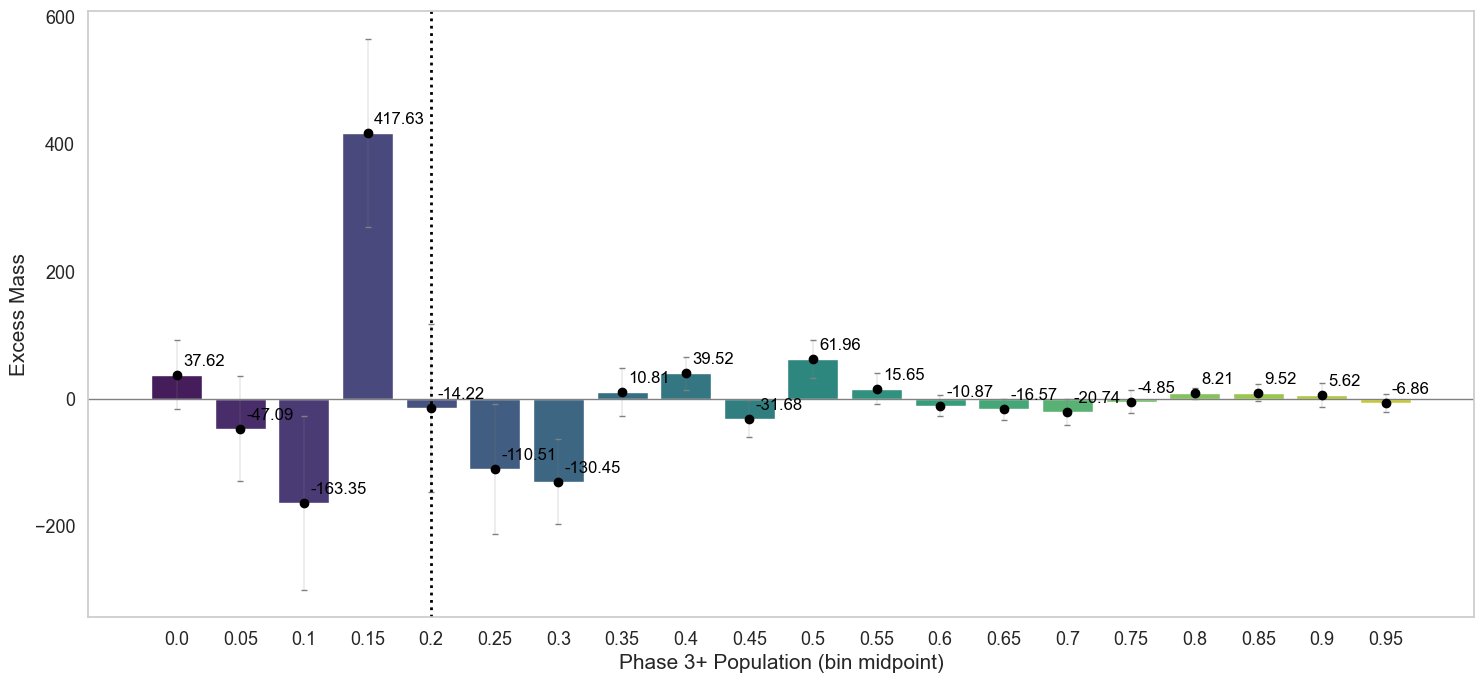

Difference per bin using 6th Polynomial Fitting


,bins,binned_data_orig,mean_coefficients,excess_mass,excess_mass_perc,t-stat,p_val
0,0.00,260,222.378681,37.621319,16.917683,1.386,0.169
1,0.05,624,671.094075,-47.094075,-7.017507,-1.143,0.256
2,0.10,735,898.349413,-163.349413,-18.183283,-2.390,0.019
3,0.15,1403,985.370266,417.629734,42.383026,5.652,0.000
4,0.20,974,988.219103,-14.219103,-1.438861,-0.216,0.829
5,0.25,833,943.512272,-110.512272,-11.712860,-2.181,0.032
6,0.30,743,873.454650,-130.454650,-14.935481,-3.916,0.000
7,0.35,801,790.191969,10.808031,1.367773,0.576,0.566
8,0.40,739,699.480817,39.519183,5.649788,3.063,0.003
9,0.45,572,603.676310,-31.676310,-5.247234,-2.169,0.032


In [56]:
# =============================================================
# Prepare Aggregated Simulation Results from Scenario 1
# =============================================================
agg_df = pd.DataFrame({
    'bins': np.round(bin_midpoints, 2),
    'binned_data_orig': binned_data_orig,
    'mean_coefficients': mean_coefficients1,
    'std_errors': std_error1
})

# Calculate excess mass and percentage
agg_df['excess_mass'] = agg_df['binned_data_orig'] - agg_df['mean_coefficients']
agg_df['excess_mass_perc'] = (agg_df['excess_mass'] / agg_df['mean_coefficients']) * 100

# Compute t-statistics and p-values (two-tailed, df = 99)
agg_df['t-stat'] = (agg_df['excess_mass'] / agg_df['std_errors']).round(3)
agg_df['p_val'] = [(2 * (1 - stats.t.cdf(np.abs(t), df=99))).round(3) for t in agg_df['t-stat']]

# =============================================================
# Visualization: Excess Mass Barplot with Error Bars
# =============================================================
fig, ax = plt.subplots(figsize=(15, 7))

sns.barplot(
    data=agg_df,
    x='bins',
    y='excess_mass',
    palette='viridis',
    ax=ax
)

# Extract bar coordinates for error bars
x_coords = [p.get_x() + p.get_width() / 2 for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]

# Plot error bars (±2 SE)
ax.errorbar(
    x=x_coords,
    y=y_coords,
    yerr=agg_df['std_errors'] * 2,
    fmt='o',
    color='black',
    ecolor='gray',
    elinewidth=0.2,
    capsize=2
)

# Reference lines
ax.axvline(x=4, color='black', linestyle=':', linewidth=2)
ax.axhline(y=0, color='gray', linewidth=1)

# Labels and titles
ax.set_xlabel('Phase 3+ Population (bin midpoint)', fontsize=15)
ax.set_ylabel('Excess Mass', fontsize=15)
ax.tick_params(axis='both', labelsize=13)
ax.grid(False)

# Annotate bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}",
                (p.get_x() + p.get_width() / 1.6, height),
                ha='left', va='center',
                xytext=(0, 10), textcoords='offset points',
                fontsize=12, color='black')

plt.tight_layout()
plt.show()

# =============================================================
# Print Results
# =============================================================
print(f"Difference per bin using {poly}th Polynomial Fitting")
display_cols = ['bins', 'binned_data_orig', 'mean_coefficients', 'excess_mass',
                'excess_mass_perc', 't-stat', 'p_val']
agg_df[display_cols]


# Figure A12. Bunching analysis results: analyzing the impact of excluded bins  

Excluded points:  0.15
Filtered_midpoints:  [0.   0.05 0.1  0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.2
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.25
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.2  0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.3
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.2  0.25 0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Poly Degree:  4


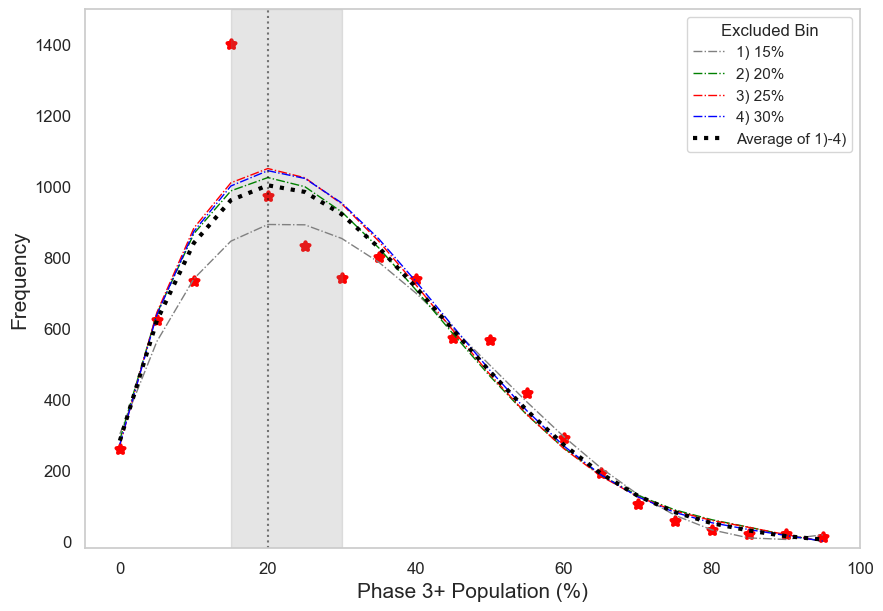

In [57]:
# =============================================================
# Set Data and Key Parameters
# =============================================================
np.random.seed(123)  
num_simulations = 500  # Number of simulations to run
poly_degree = 4 
var = 'phase3plus_perc'  # Column name to be analyzed

# Prepare the Data
sub_df = rounded_df.copy() 
data = sub_df[f'{var}']  # Extract the data from the specified column
data_size = len(data)

# Step 1: Original Density Setup
zstar = 0.20  # Exclusion threshold value for bin filtering in simulations
binwidth = 0.05  # Width of each bin for histogramming data

# Create bins and bin midpoints for histogram calculations
bins_orig = np.arange(0, 1 + binwidth, binwidth)
binned_data_orig, _ = np.histogram(data.round(2), bins_orig.round(2))
bin_midpoints_orig = (bins_orig[:-1] + bins_orig[1:]) / 2

bins = np.arange(0, 1 + binwidth, binwidth)
bin_midpoints = ((bins[:-1] + bins[1:]) / 2).round(3)

# =============================================================
# Simulation 1: Sequential Exclusion Simulation
# =============================================================

# Initialize arrays to store polynomial coefficients for each exclusion
coefficients_matrix_125 = np.zeros((num_simulations, 20))
coefficients_matrix_175 = np.zeros((num_simulations, 20))
coefficients_matrix_225 = np.zeros((num_simulations, 20))
coefficients_matrix_275 = np.zeros((num_simulations, 20))
coefficients_matrix_325 = np.zeros((num_simulations, 20))

# Define bin midpoints to exclude
exclude_points = [0.175, 0.225, 0.275, 0.325]

# Loop through each exclusion point and perform simulations
for k in range(len(exclude_points)):
    print('Excluded points: ', exclude_points[k] - 0.025)
    
    for j in range(num_simulations):
        simulated_data = data.sample(len(data), replace=True)
        binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))

        filtered_midpoints = bin_midpoints[bin_midpoints != exclude_points[k]]
        filtered_counts = binned_data[bin_midpoints != exclude_points[k]]

        coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
        poly_func = np.poly1d(coefficients)
        
        x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
        y_poly = poly_func(x_poly)
        y_poly = np.where(y_poly < 0, 0, y_poly)  # Remove negatives

        if k == 0:
            coefficients_matrix_175[j, :] = y_poly
        elif k == 1:
            coefficients_matrix_225[j, :] = y_poly
        elif k == 2:
            coefficients_matrix_275[j, :] = y_poly
        else:
            coefficients_matrix_325[j, :] = y_poly

    print('Filtered_midpoints: ', filtered_midpoints - 0.025)

# =============================================================
# Combine Results and Plot
# =============================================================
all_coefficients_matrix = np.vstack((coefficients_matrix_175,
                                     coefficients_matrix_225,
                                     coefficients_matrix_275,
                                     coefficients_matrix_325))

mean_coefficients1 = np.mean(all_coefficients_matrix, axis=0)
std_devs1 = np.std(all_coefficients_matrix, axis=0, ddof=1)

print('Poly Degree: ', poly_degree)

plt.figure(figsize=(10, 7))

# Plot 1 - Original binned data
plt.scatter(bin_midpoints_orig - 0.025, binned_data_orig,
            label="Binned Data", color='red', marker='*', linewidth=3)

# Plot 2 - Simulation curves
for i, c in zip([coefficients_matrix_175, coefficients_matrix_225,
                 coefficients_matrix_275, coefficients_matrix_325,
                 [coefficients_matrix_175, coefficients_matrix_225,
                  coefficients_matrix_275, coefficients_matrix_325]],
                ['gray', 'green', 'red', 'blue', 'black']):

    all_coefficients_matrix = np.vstack((i))
    mean_coefficient1 = np.mean(all_coefficients_matrix, axis=0)
    std_error1 = np.std(all_coefficients_matrix, axis=0, ddof=1)

    if i[0].shape[0] > 20:
        plt.plot(bin_midpoints - 0.025, mean_coefficient1,
                 color=c, alpha=1, linewidth=3, linestyle=':')
    else:
        plt.plot(bin_midpoints - 0.025, mean_coefficient1,
                 color=c, alpha=1, linewidth=1, linestyle='-.')

# Reference Lines
plt.axvline(x=0.20, color='black', alpha=0.5, linestyle=':')
plt.axvspan(0.15, 0.30, color='gray', alpha=0.2)
plt.ylim(-20, 1500)

# Axis Formatting
locations, labels = plt.xticks()
plt.xticks(ticks=locations[:-1] + 0.2, labels=np.arange(0, 120, 20))
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)

# Labels and Legend
plt.xlabel('Phase 3+ Population (%)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.grid(False)
plt.legend(title='Excluded Bin',
           labels=['1) 15%', '2) 20%', '3) 25%', '4) 30%', 'Average of 1)-4)'])


# Figure A13. Histograms of rounded and unrounded IPC assessments defined by the proportion of population in phase 3+ (%)

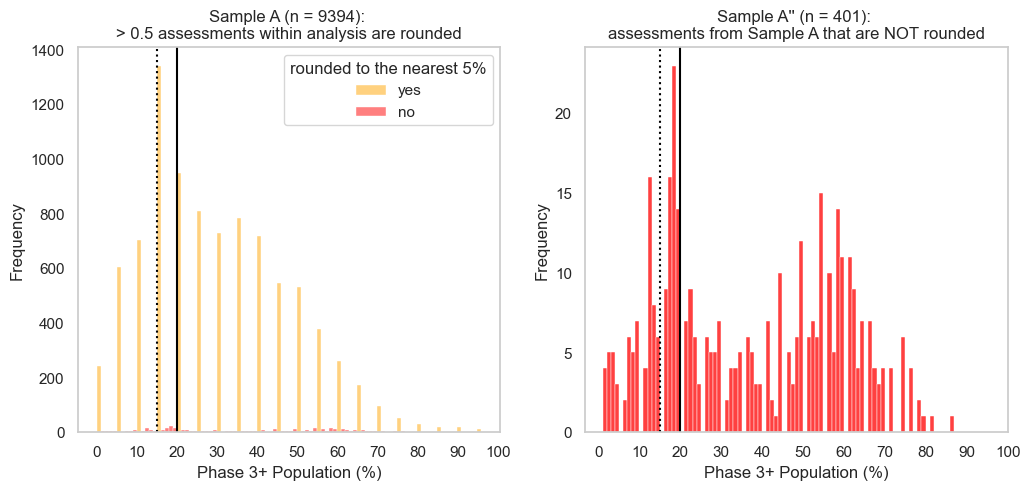

In [58]:
# =============================================================
# Compare Rounded vs Non-Rounded Phase 3+ Population (%) Shares
# =============================================================

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

var = 'phase3plus_perc'

# Label whether the data is rounded to the nearest 5%
rounded_df['rounded to the nearest 5%'] = np.where(
    rounded_df[var].isin(roundnumber), 'yes', 'no'
)

# --------------------------------------------
# Left Plot: Full Sample A with Color by Rounding
# --------------------------------------------
sns.histplot(
    data=rounded_df,
    x=var,
    binwidth=0.00999,
    ax=ax[0],
    hue='rounded to the nearest 5%',
    kde=False,
    palette={'yes': 'orange', 'no': 'red'}
)

# Add vertical lines
ax[0].axvline(x=0.20, color='black')
ax[0].axvline(x=0.15, color='black', linestyle=':')

# Customize axis labels and title
ax[0].set_xlabel('Phase 3+ Population (%)', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].set_title(
    f"Sample A (n = {len(rounded_df)}): \n> 0.5 assessments within analysis are rounded"
)

# Set x-axis ticks and labels
locations = np.arange(0, 1.1, 0.1)
ax[0].set_xticks(locations)
ax[0].set_xticklabels(np.arange(0, 110, 10))

# --------------------------------------------
# Right Plot: Non-Rounded Only from Sample A
# --------------------------------------------
non_rounded_data = rounded_df[~rounded_df[var].isin(np.arange(0, 1, 0.05).round(2))][var]

sns.histplot(
    non_rounded_data,
    binwidth=0.00999,
    ax=ax[1],
    kde=False,
    color='red'
)

# Add vertical lines
ax[1].axvline(x=0.20, color='black')
ax[1].axvline(x=0.15, color='black', linestyle=':')

# Customize axis labels and title
ax[1].set_xlabel('Phase 3+ Population (%)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].set_title(
    f"Sample A'' (n = {len(non_rounded_data)}): \nassessments from Sample A that are NOT rounded"
)

# Set x-axis ticks and labels
ax[1].set_xticks(locations)
ax[1].set_xticklabels(np.arange(0, 110, 10))

# Remove grid for both plots
ax[0].grid(False)
ax[1].grid(False)


# Figure A14. Histograms of rounded and unrounded IPC assessments defined by the proportion of population in phase 4+ (%)

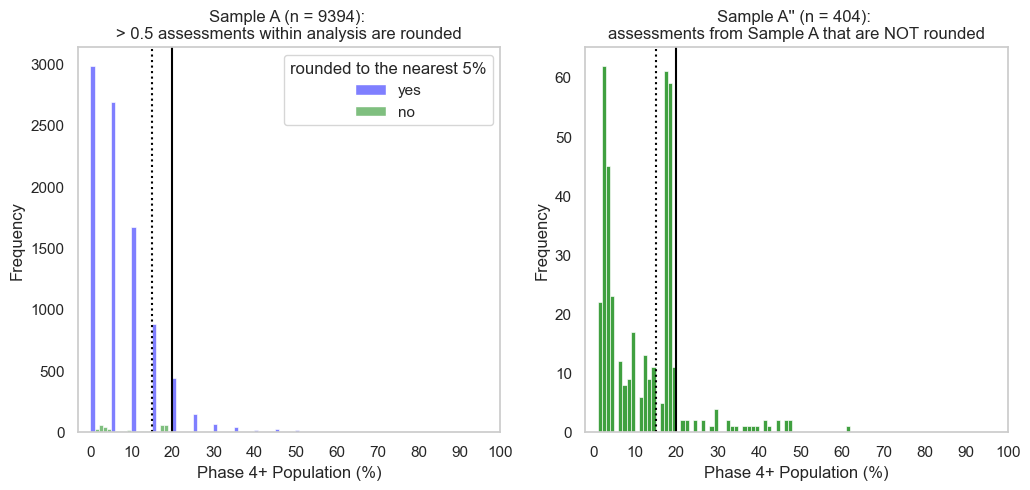

In [59]:
# =============================================================
# Compare Rounded vs Non-Rounded Phase 4+ Population (%) Shares
# =============================================================

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

var = 'phase4plus_perc'

# Label whether the data is rounded to the nearest 5%
rounded_df['rounded to the nearest 5%'] = np.where(
    rounded_df[var].isin(roundnumber), 'yes', 'no'
)

# --------------------------------------------
# Left Plot: Full Sample A with Color by Rounding
# --------------------------------------------
sns.histplot(
    data=rounded_df,
    x=var,
    binwidth=0.00999,
    ax=ax[0],
    hue='rounded to the nearest 5%',
    kde=False,
    palette={'yes': 'blue', 'no': 'green'}
)

# Add vertical lines
ax[0].axvline(x=0.20, color='black')
ax[0].axvline(x=0.15, color='black', linestyle=':')

# Customize axis labels and title
ax[0].set_xlabel('Phase 4+ Population (%)', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].set_title(
    f"Sample A (n = {len(rounded_df)}): \n> 0.5 assessments within analysis are rounded"
)

# Set x-axis ticks and labels
locations = np.arange(0, 1.1, 0.1)
ax[0].set_xticks(locations)
ax[0].set_xticklabels(np.arange(0, 110, 10))

# --------------------------------------------
# Right Plot: Non-Rounded Only from Sample A
# --------------------------------------------
non_rounded_data = rounded_df[~rounded_df[var].isin(np.arange(0, 1, 0.05).round(2))][var]

sns.histplot(
    non_rounded_data,
    binwidth=0.00999,
    ax=ax[1],
    kde=False,
    color='green'
)

# Add vertical lines
ax[1].axvline(x=0.20, color='black')
ax[1].axvline(x=0.15, color='black', linestyle=':')

# Customize axis labels and title
ax[1].set_xlabel('Phase 4+ Population (%)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].set_title(
    f"Sample A'' (n = {len(non_rounded_data)}): \nassessments from Sample A that are NOT rounded"
)

# Set x-axis ticks and labels
ax[1].set_xticks(locations)
ax[1].set_xticklabels(np.arange(0, 110, 10))

# Remove grid for both plots
ax[0].grid(False)
ax[1].grid(False)


# Figure A15. Observed and estimated distributions of IPC assessments defined by the proportion of population in phase 3+by available group of FSIs 

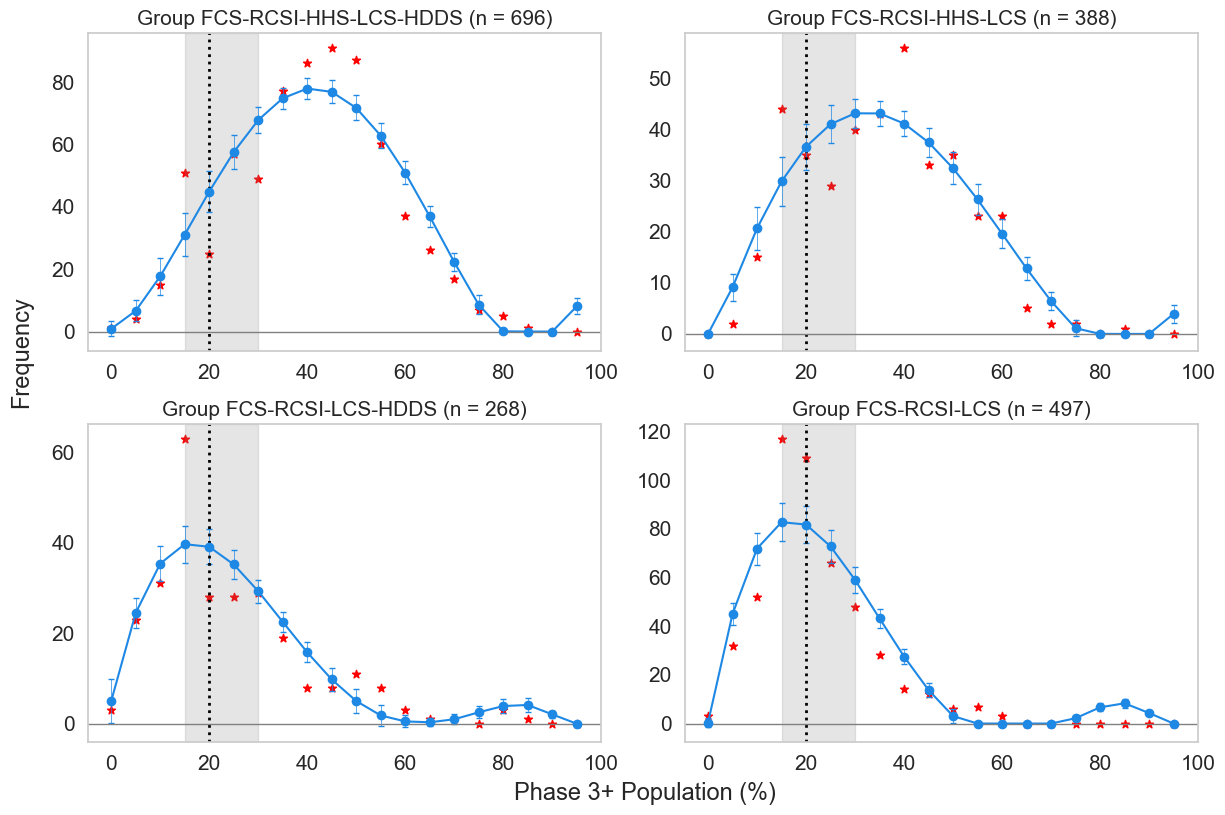

In [60]:
# ================================================
# Simulation-Based Density Smoothing by Group
# ================================================

sub_df = ipc_df_sub.copy()
groups = sub_df['FSI_combination'].unique()

# Set up parameters
np.random.seed(1234)
num_simulations = 500
poly_degree = 4
binwidth = 0.05
bins = np.arange(0, 1 + binwidth, binwidth)
bin_midpoints = (bins[:-1] + bins[1:]) / 2

# Set-up Subplots
fig, axes = plt.subplots(len(groups)//2, 2, figsize=(12, len(groups)//2 * 4))
axes = axes.flatten()

aggre_df = []

# Loop through each group
for i, group in enumerate(groups):
    group_data = sub_df[sub_df['FSI_combination'] == group]['phase3_plus']
    data_size = len(group_data)
    ax = axes[i]

    # Histogram the original group data
    bins_orig = np.arange(0, 1 + binwidth, binwidth)
    binned_data_orig, _ = np.histogram(group_data.round(2), bins_orig.round(2))
    bin_midpoints_orig = (bins_orig[:-1] + bins_orig[1:]) / 2

    # Initialize matrices for simulation results
    coefficients_matrix_175 = np.zeros((num_simulations, 20))
    coefficients_matrix_225 = np.zeros((num_simulations, 20))
    coefficients_matrix_275 = np.zeros((num_simulations, 20))
    coefficients_matrix_325 = np.zeros((num_simulations, 20))

    exclude_points = [0.175, 0.225, 0.275, 0.325]

    for k, exclude in enumerate(exclude_points):
        for j in range(num_simulations):
            simulated_data = group_data.sample(data_size, replace=True)
            binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))

            filtered_midpoints = bin_midpoints[bin_midpoints != round(exclude, 3)]
            filtered_counts = binned_data[bin_midpoints != round(exclude, 3)]

            coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
            poly_func = np.poly1d(coefficients)

            x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
            y_poly = np.clip(poly_func(x_poly), 0, None)

            if k == 0:
                coefficients_matrix_175[j, :] = y_poly
            elif k == 1:
                coefficients_matrix_225[j, :] = y_poly
            elif k == 2:
                coefficients_matrix_275[j, :] = y_poly
            else:
                coefficients_matrix_325[j, :] = y_poly

    all_coefficients_matrix = np.vstack([
        coefficients_matrix_175,
        coefficients_matrix_225,
        coefficients_matrix_275,
        coefficients_matrix_325
    ])

    mean_coefficients = np.mean(all_coefficients_matrix, axis=0)
    std_errors = np.std(all_coefficients_matrix, axis=0, ddof=1)

    agg_df = pd.DataFrame({
        'bins': bin_midpoints - 0.025,
        'binned_data_orig': binned_data_orig,
        'mean_coefficients': mean_coefficients,
        'std_errors1': std_errors
    })

    aggre_df.append(agg_df)

    # Plotting
    ax.scatter(bin_midpoints_orig - 0.025, binned_data_orig, color='red', marker='*', label="Binned Data")
    ax.errorbar(bin_midpoints - 0.025, mean_coefficients, yerr=std_errors * 1.96,
                fmt='o', color='#1E88E5', ecolor='#1E88E5', elinewidth=0.5, capsize=2)
    ax.plot(bin_midpoints - 0.025, mean_coefficients, color='#1E88E5')

    ax.axvspan(0.15, 0.30, color='gray', alpha=0.2)
    ax.axvline(x=0.20, color='black', linestyle=':', linewidth=2)
    ax.axhline(y=0, color='gray', linewidth=1)

    ax.set_title(f'Group {group} (n = {len(group_data)})', fontsize=15)
    ax.set_xticks(np.arange(0, 1.05, 0.2))
    ax.set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)])
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(False)

# Global axis labels
plt.tight_layout()
fig.text(0.4, -0.01, 'Phase 3+ Population (%)', fontsize=17)
fig.text(-0.01, 0.55, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=17)

plt.show()


# Figure A16. Year-specific distribution of IPC assessments defined by the proportion of population in phase 3+ (%)

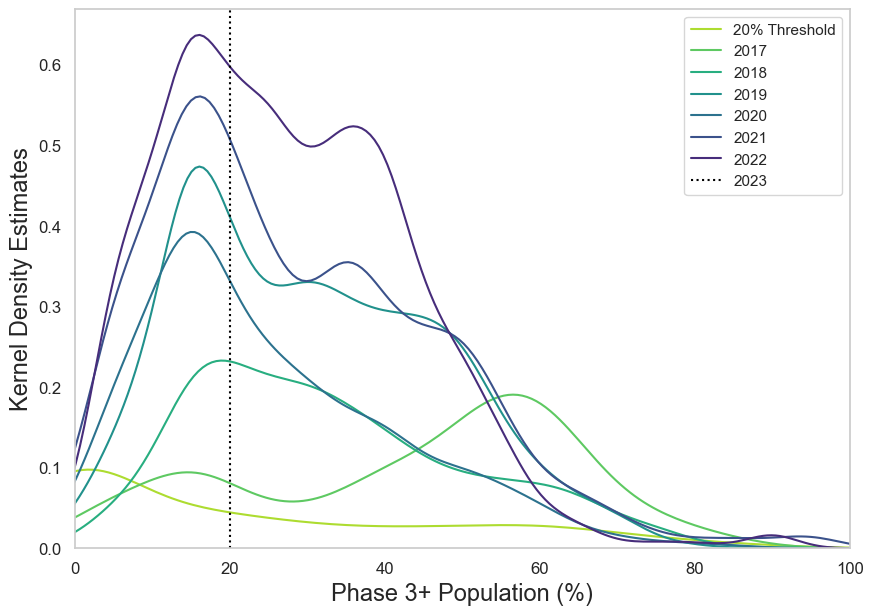

In [61]:
# =======================================================
# Kernel Density Plot of Phase 3+ by Year (2017–2023)
# =======================================================

plt.figure(figsize=(10, 7))

# KDE Plot
ax = sns.kdeplot(
    data=rounded_df[rounded_df['year'].isin(['2017', '2018', '2019', '2020', '2021', '2022', '2023'])],
    x='phase3plus_perc',
    hue='year',
    bw_adjust=1,
    palette='viridis'
)

# Reference Line at 20%
ax.axvline(x=0.2, color='black', linestyle=':')

# Axes Labels
ax.set_xlabel('Phase 3+ Population (%)', fontsize=17)
ax.set_ylabel('Kernel Density Estimates', fontsize=17)

# Custom Tick Formatting
ax.set_xticks(np.arange(0, 1.05, 0.2))
ax.set_xticklabels([f'{x * 100:.0f}' for x in np.arange(0, 1.05, 0.2)])
ax.set_xlim([0, 1])

# Axis Ticks Font Size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Legend Manual Order
ax.legend(['20% Threshold'] + ['2017', '2018', '2019', '2020', '2021', '2022', '2023'])

# Remove Grid
ax.grid(False)
